# Explore the GAN Latent Space With the Large-scale CelebFaces Attributes Dataset

See also the notebook GAN Basics 2.

1. Download the dataset from https://www.kaggle.com/jessicali9530/celeba-dataset and extract the images to a folder 'img_align_celeba'
2. pip install mtcnn

Based upon article: https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/

In [34]:
from os import listdir
from PIL import Image
from mtcnn.mtcnn import MTCNN
import numpy as np
from numpy import asarray, savez_compressed, load, zeros, ones, vstack
from numpy import arccos, clip, dot, mean, sin, linspace, expand_dims
from numpy.random import randn, randint
from numpy.linalg import norm
from keras.optimizers import Adam
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot

## Analyse and Prepare Dataset
To help with the training we will crop only the face part from the images using MTCNN face detector.

In [2]:
# load an image as an rgb numpy array
def load_image(filename):
    image = Image.open(filename)
    image = image.convert('RGB')
    pixels = asarray(image)
    return pixels

# extract the face from a loaded image and resize
def extract_face(model, pixels, required_size=(80, 80)):
    # detect face in the image
    faces = model.detect_faces(pixels)
    # skip cases where we could not detect a face
    if len(faces) == 0:
        return None
    # extract details of the face
    x1, y1, width, height = faces[0]['box']
    # force detected pixel values to be positive (bug fix)
    x1, y1 = abs(x1), abs(y1)
    # convert into coordinates
    x2, y2 = x1 + width, y1 + height
    # retrieve face pixels
    face_pixels = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face_pixels)
    image = image.resize(required_size)
    face_array = asarray(image)
    return face_array

# load images and extract faces for all images in a directory
def load_faces(directory, n_faces, should_extract_face=True):
    # prepare model
    model = MTCNN()
    faces = list()
    for filename in listdir(directory):
        face = load_image(directory + filename)
        if should_extract_face:
            face = extract_face(model, face)
        if face is None:
            continue
        faces.append(face)
        #print(len(faces), face.shape)
        # stop once we have enough
        if len(faces) >= n_faces:
            break
    return asarray(faces)

# plot a list of loaded faces
def plot_faces(faces, n):
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(faces[i])
    pyplot.show()

Display some faces both cropped and uncropped.

W0730 19:19:26.479966  6148 deprecation_wrapper.py:119] From C:\applications\Miniconda3\envs\tf-gpu\lib\site-packages\mtcnn\mtcnn.py:187: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0730 19:19:26.490994  6148 deprecation_wrapper.py:119] From C:\applications\Miniconda3\envs\tf-gpu\lib\site-packages\mtcnn\mtcnn.py:193: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0730 19:19:27.347119  6148 deprecation_wrapper.py:119] From C:\applications\Miniconda3\envs\tf-gpu\lib\site-packages\mtcnn\network.py:43: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0730 19:19:27.348120  6148 deprecation_wrapper.py:119] From C:\applications\Miniconda3\envs\tf-gpu\lib\site-packages\mtcnn\layer_factory.py:88: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0730 19:19:27.350121  6148 deprecation_wrapper.py:119] From C:\applications\Miniconda3\envs\tf-gpu\li

Loaded:  (25, 218, 178, 3)


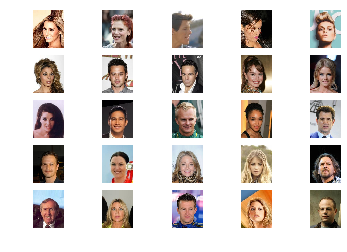

Loaded:  (25, 80, 80, 3)


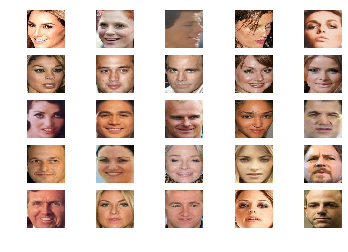

In [3]:
# directory that contains all images
directory = 'img_align_celeba/'

# load faces for plotting
faces = load_faces(directory, 25, False)
print('Loaded: ', faces.shape)
plot_faces(faces, 5)

# load and extract faces for plotting
faces = load_faces(directory, 25, True)
print('Loaded: ', faces.shape)
plot_faces(faces, 5)

Load and crop faces for use with out GAN. We save these out to an compressed file to save the need for any reprocessing. 

NOTE: This can take a (very) long time to run!

In [14]:
# load and extract all faces
all_faces = load_faces(directory, 50000)
print('Loaded: ', all_faces.shape)
# save in compressed format
savez_compressed('img_align_celeba.npz', all_faces)

Loaded:  (50000, 80, 80, 3)


## Create and Train GAN
See the GAN Basics notebooks for a more detailed overview on what these functions do.

In [3]:
# define the standalone discriminator model
def define_discriminator(in_shape=(80,80,3)):
    model = Sequential()
    # normal
    model.add(Conv2D(128, (5,5), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 40x40
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 20x30
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 10x10
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # downsample to 5x5
    model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    # foundation for 5x5 feature maps
    n_nodes = 128 * 5 * 5
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((5, 5, 128)))
    # upsample to 10x10
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 20x20
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 40x40
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # upsample to 80x80
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # output layer 80x80x3
    model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(g_model)
    # add the discriminator
    model.add(d_model)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load and prepare training images
def load_real_samples():
    # load the face dataset
    data = load('img_align_celeba.npz')
    X = data['arr_0']
    # convert from unsigned ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

# create and save a plot of generated images
def save_plot(examples, epoch, n=10):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i])
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    save_plot(x_fake, epoch)
    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)
    
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # update discriminator model weights on randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            
            # update discriminator model weights on 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)           
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            
            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
            
        # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)           

In [11]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data

# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

C:\applications\Miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
C:\applications\Miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 1/390, d1=0.692, d2=0.696 g=0.692


C:\applications\Miniconda3\envs\tf-gpu\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 2/390, d1=0.541, d2=0.697 g=0.691
>1, 3/390, d1=0.200, d2=0.710 g=0.687
>1, 4/390, d1=0.006, d2=0.728 g=0.691
>1, 5/390, d1=0.002, d2=0.721 g=0.697
>1, 6/390, d1=0.002, d2=0.690 g=0.705
>1, 7/390, d1=0.003, d2=0.684 g=0.720
>1, 8/390, d1=0.004, d2=0.676 g=0.759
>1, 9/390, d1=0.006, d2=0.642 g=0.840
>1, 10/390, d1=0.022, d2=0.622 g=0.868
>1, 11/390, d1=0.002, d2=0.554 g=1.081
>1, 12/390, d1=0.000, d2=0.391 g=1.686
>1, 13/390, d1=0.012, d2=0.206 g=2.579
>1, 14/390, d1=0.000, d2=0.053 g=4.118
>1, 15/390, d1=0.000, d2=0.009 g=5.403
>1, 16/390, d1=0.000, d2=0.004 g=5.942
>1, 17/390, d1=0.000, d2=0.006 g=6.021
>1, 18/390, d1=0.000, d2=0.049 g=10.383
>1, 19/390, d1=0.000, d2=0.000 g=15.430
>1, 20/390, d1=0.000, d2=0.000 g=13.821
>1, 21/390, d1=0.000, d2=0.000 g=9.408
>1, 22/390, d1=0.000, d2=3.737 g=16.117
>1, 23/390, d1=0.000, d2=0.000 g=16.118
>1, 24/390, d1=0.343, d2=0.000 g=16.118
>1, 25/390, d1=0.000, d2=0.000 g=16.109
>1, 26/390, d1=0.000, d2=0.000 g=16.035
>1, 27/390, d1=0.000, d2=

>1, 206/390, d1=0.000, d2=0.000 g=16.118
>1, 207/390, d1=0.000, d2=0.000 g=16.118
>1, 208/390, d1=0.000, d2=0.000 g=16.118
>1, 209/390, d1=0.000, d2=0.000 g=16.118
>1, 210/390, d1=0.000, d2=0.000 g=16.118
>1, 211/390, d1=0.000, d2=0.000 g=16.118
>1, 212/390, d1=0.000, d2=0.000 g=16.118
>1, 213/390, d1=0.000, d2=0.000 g=16.118
>1, 214/390, d1=0.000, d2=0.000 g=16.118
>1, 215/390, d1=0.000, d2=0.000 g=16.118
>1, 216/390, d1=0.000, d2=0.000 g=16.118
>1, 217/390, d1=0.000, d2=0.000 g=16.118
>1, 218/390, d1=0.000, d2=0.000 g=16.118
>1, 219/390, d1=0.000, d2=0.000 g=16.118
>1, 220/390, d1=0.000, d2=0.000 g=16.118
>1, 221/390, d1=0.000, d2=0.000 g=16.118
>1, 222/390, d1=0.000, d2=0.000 g=16.118
>1, 223/390, d1=0.000, d2=0.000 g=16.118
>1, 224/390, d1=0.000, d2=0.000 g=16.118
>1, 225/390, d1=0.000, d2=0.000 g=16.118
>1, 226/390, d1=0.000, d2=0.000 g=16.118
>1, 227/390, d1=0.000, d2=0.000 g=16.118
>1, 228/390, d1=0.000, d2=0.000 g=16.118
>1, 229/390, d1=0.000, d2=0.000 g=16.117
>1, 230/390, d1=

>2, 20/390, d1=0.280, d2=0.242 g=5.152
>2, 21/390, d1=0.295, d2=0.109 g=4.539
>2, 22/390, d1=0.277, d2=0.413 g=6.933
>2, 23/390, d1=0.884, d2=0.799 g=4.960
>2, 24/390, d1=0.771, d2=0.412 g=3.004
>2, 25/390, d1=0.392, d2=0.408 g=2.477
>2, 26/390, d1=0.269, d2=0.428 g=2.332
>2, 27/390, d1=0.252, d2=0.262 g=2.045
>2, 28/390, d1=0.212, d2=0.419 g=2.090
>2, 29/390, d1=0.256, d2=0.403 g=2.084
>2, 30/390, d1=0.256, d2=0.394 g=3.444
>2, 31/390, d1=0.315, d2=0.221 g=5.469
>2, 32/390, d1=0.170, d2=0.038 g=5.589
>2, 33/390, d1=0.161, d2=0.372 g=7.206
>2, 34/390, d1=0.229, d2=0.049 g=6.456
>2, 35/390, d1=0.231, d2=0.065 g=5.061
>2, 36/390, d1=0.325, d2=0.387 g=11.358
>2, 37/390, d1=0.802, d2=0.004 g=5.376
>2, 38/390, d1=0.143, d2=0.023 g=3.779
>2, 39/390, d1=0.023, d2=0.052 g=3.437
>2, 40/390, d1=0.056, d2=0.055 g=3.368
>2, 41/390, d1=0.031, d2=0.071 g=3.507
>2, 42/390, d1=0.069, d2=0.059 g=3.481
>2, 43/390, d1=0.068, d2=0.062 g=3.609
>2, 44/390, d1=0.129, d2=0.078 g=3.507
>2, 45/390, d1=0.058, d2

>2, 227/390, d1=0.124, d2=0.130 g=4.698
>2, 228/390, d1=0.232, d2=0.157 g=4.483
>2, 229/390, d1=0.079, d2=0.259 g=5.678
>2, 230/390, d1=0.659, d2=1.198 g=4.277
>2, 231/390, d1=0.296, d2=0.076 g=4.502
>2, 232/390, d1=0.394, d2=0.470 g=2.959
>2, 233/390, d1=0.217, d2=0.149 g=3.193
>2, 234/390, d1=0.226, d2=0.212 g=4.011
>2, 235/390, d1=0.174, d2=0.159 g=4.076
>2, 236/390, d1=0.300, d2=0.343 g=5.292
>2, 237/390, d1=0.330, d2=0.148 g=4.582
>2, 238/390, d1=0.322, d2=0.227 g=3.723
>2, 239/390, d1=0.220, d2=0.271 g=4.351
>2, 240/390, d1=0.342, d2=0.143 g=3.634
>2, 241/390, d1=0.225, d2=0.268 g=3.970
>2, 242/390, d1=0.189, d2=0.227 g=5.328
>2, 243/390, d1=0.445, d2=0.178 g=3.705
>2, 244/390, d1=0.184, d2=0.274 g=3.900
>2, 245/390, d1=0.319, d2=0.357 g=4.047
>2, 246/390, d1=0.353, d2=0.369 g=5.470
>2, 247/390, d1=0.452, d2=0.169 g=4.334
>2, 248/390, d1=0.358, d2=0.311 g=4.331
>2, 249/390, d1=0.622, d2=0.638 g=4.250
>2, 250/390, d1=0.452, d2=0.207 g=3.169
>2, 251/390, d1=0.289, d2=0.292 g=3.063


>3, 44/390, d1=0.252, d2=0.321 g=3.129
>3, 45/390, d1=0.324, d2=0.211 g=2.915
>3, 46/390, d1=0.211, d2=0.230 g=2.929
>3, 47/390, d1=0.403, d2=0.236 g=2.426
>3, 48/390, d1=0.238, d2=0.278 g=2.542
>3, 49/390, d1=0.247, d2=0.210 g=2.586
>3, 50/390, d1=0.273, d2=0.222 g=2.689
>3, 51/390, d1=0.269, d2=0.290 g=2.818
>3, 52/390, d1=0.449, d2=0.404 g=3.163
>3, 53/390, d1=0.269, d2=0.222 g=3.662
>3, 54/390, d1=0.264, d2=0.286 g=3.978
>3, 55/390, d1=0.282, d2=0.217 g=4.604
>3, 56/390, d1=0.251, d2=0.120 g=4.540
>3, 57/390, d1=0.170, d2=0.369 g=5.366
>3, 58/390, d1=0.218, d2=0.036 g=4.685
>3, 59/390, d1=0.086, d2=0.100 g=4.342
>3, 60/390, d1=0.263, d2=0.282 g=5.931
>3, 61/390, d1=0.324, d2=0.174 g=4.816
>3, 62/390, d1=0.419, d2=0.813 g=4.201
>3, 63/390, d1=0.306, d2=0.070 g=3.845
>3, 64/390, d1=0.299, d2=0.445 g=3.385
>3, 65/390, d1=0.263, d2=0.236 g=3.629
>3, 66/390, d1=0.519, d2=0.586 g=3.564
>3, 67/390, d1=0.490, d2=0.541 g=3.997
>3, 68/390, d1=0.809, d2=0.819 g=3.406
>3, 69/390, d1=0.949, d2=

>3, 251/390, d1=0.255, d2=0.412 g=4.579
>3, 252/390, d1=0.317, d2=0.115 g=3.720
>3, 253/390, d1=0.228, d2=0.599 g=5.223
>3, 254/390, d1=0.591, d2=0.149 g=3.574
>3, 255/390, d1=0.200, d2=0.472 g=3.772
>3, 256/390, d1=0.321, d2=0.130 g=3.225
>3, 257/390, d1=0.168, d2=0.209 g=3.567
>3, 258/390, d1=0.227, d2=0.139 g=3.572
>3, 259/390, d1=0.188, d2=0.162 g=3.522
>3, 260/390, d1=0.243, d2=0.347 g=4.025
>3, 261/390, d1=0.277, d2=0.116 g=3.242
>3, 262/390, d1=0.212, d2=0.341 g=4.215
>3, 263/390, d1=0.297, d2=0.187 g=4.054
>3, 264/390, d1=0.221, d2=0.174 g=3.747
>3, 265/390, d1=0.140, d2=0.194 g=3.952
>3, 266/390, d1=0.301, d2=0.180 g=3.740
>3, 267/390, d1=0.103, d2=0.235 g=4.458
>3, 268/390, d1=0.502, d2=0.306 g=3.478
>3, 269/390, d1=0.213, d2=0.408 g=4.299
>3, 270/390, d1=0.605, d2=0.753 g=3.860
>3, 271/390, d1=0.516, d2=0.508 g=4.342
>3, 272/390, d1=0.607, d2=0.599 g=4.481
>3, 273/390, d1=0.663, d2=0.301 g=3.114
>3, 274/390, d1=0.253, d2=0.362 g=3.929
>3, 275/390, d1=0.436, d2=0.214 g=3.095


>4, 68/390, d1=0.423, d2=0.261 g=3.603
>4, 69/390, d1=0.301, d2=0.248 g=3.433
>4, 70/390, d1=0.191, d2=0.241 g=3.958
>4, 71/390, d1=0.299, d2=0.387 g=4.080
>4, 72/390, d1=0.434, d2=0.399 g=4.414
>4, 73/390, d1=0.174, d2=0.263 g=5.215
>4, 74/390, d1=0.363, d2=0.245 g=3.854
>4, 75/390, d1=0.336, d2=0.563 g=5.162
>4, 76/390, d1=0.709, d2=0.444 g=3.996
>4, 77/390, d1=0.330, d2=0.244 g=3.742
>4, 78/390, d1=0.352, d2=0.402 g=3.673
>4, 79/390, d1=0.329, d2=0.227 g=3.488
>4, 80/390, d1=0.325, d2=0.267 g=3.282
>4, 81/390, d1=0.339, d2=0.168 g=2.955
>4, 82/390, d1=0.170, d2=0.306 g=3.576
>4, 83/390, d1=0.231, d2=0.200 g=3.808
>4, 84/390, d1=0.208, d2=0.402 g=5.171
>4, 85/390, d1=0.356, d2=0.086 g=4.453
>4, 86/390, d1=0.301, d2=0.285 g=4.331
>4, 87/390, d1=0.238, d2=0.126 g=4.269
>4, 88/390, d1=0.283, d2=0.470 g=5.097
>4, 89/390, d1=0.575, d2=0.107 g=3.819
>4, 90/390, d1=0.214, d2=0.215 g=3.807
>4, 91/390, d1=0.098, d2=0.097 g=4.150
>4, 92/390, d1=0.244, d2=0.297 g=4.885
>4, 93/390, d1=0.138, d2=

>4, 274/390, d1=0.187, d2=0.203 g=3.681
>4, 275/390, d1=0.141, d2=0.228 g=4.305
>4, 276/390, d1=0.194, d2=0.141 g=4.164
>4, 277/390, d1=0.420, d2=0.571 g=5.384
>4, 278/390, d1=0.405, d2=0.051 g=3.792
>4, 279/390, d1=0.239, d2=0.401 g=4.171
>4, 280/390, d1=0.368, d2=0.178 g=4.372
>4, 281/390, d1=0.237, d2=0.139 g=4.124
>4, 282/390, d1=0.240, d2=0.239 g=4.491
>4, 283/390, d1=0.154, d2=0.070 g=4.030
>4, 284/390, d1=0.199, d2=0.219 g=4.202
>4, 285/390, d1=0.257, d2=0.084 g=3.397
>4, 286/390, d1=0.222, d2=0.308 g=3.898
>4, 287/390, d1=0.183, d2=0.146 g=4.413
>4, 288/390, d1=0.216, d2=0.135 g=4.035
>4, 289/390, d1=0.226, d2=0.298 g=5.107
>4, 290/390, d1=0.273, d2=0.052 g=3.784
>4, 291/390, d1=0.083, d2=0.256 g=4.559
>4, 292/390, d1=0.289, d2=0.108 g=3.829
>4, 293/390, d1=0.190, d2=0.315 g=5.054
>4, 294/390, d1=0.493, d2=0.260 g=4.264
>4, 295/390, d1=0.228, d2=0.280 g=4.394
>4, 296/390, d1=0.506, d2=0.336 g=3.366
>4, 297/390, d1=0.245, d2=0.245 g=3.523
>4, 298/390, d1=0.214, d2=0.171 g=4.114


>5, 92/390, d1=0.315, d2=0.191 g=3.841
>5, 93/390, d1=0.316, d2=0.240 g=3.918
>5, 94/390, d1=0.177, d2=0.145 g=4.606
>5, 95/390, d1=0.179, d2=0.166 g=4.815
>5, 96/390, d1=0.371, d2=0.274 g=4.257
>5, 97/390, d1=0.099, d2=0.100 g=4.301
>5, 98/390, d1=0.338, d2=0.377 g=5.127
>5, 99/390, d1=0.315, d2=0.225 g=5.150
>5, 100/390, d1=0.375, d2=0.279 g=4.925
>5, 101/390, d1=0.286, d2=0.116 g=4.514
>5, 102/390, d1=0.160, d2=0.196 g=4.044
>5, 103/390, d1=0.166, d2=0.174 g=3.968
>5, 104/390, d1=0.224, d2=0.215 g=4.097
>5, 105/390, d1=0.576, d2=0.379 g=4.365
>5, 106/390, d1=0.192, d2=0.061 g=3.923
>5, 107/390, d1=0.236, d2=0.182 g=3.414
>5, 108/390, d1=0.095, d2=0.317 g=4.703
>5, 109/390, d1=0.442, d2=0.198 g=3.949
>5, 110/390, d1=0.223, d2=0.212 g=4.305
>5, 111/390, d1=0.201, d2=0.187 g=4.551
>5, 112/390, d1=0.189, d2=0.241 g=4.563
>5, 113/390, d1=0.289, d2=0.249 g=4.857
>5, 114/390, d1=0.327, d2=0.280 g=5.010
>5, 115/390, d1=0.457, d2=0.302 g=4.775
>5, 116/390, d1=0.307, d2=0.281 g=4.254
>5, 117/

>5, 298/390, d1=0.349, d2=0.263 g=3.414
>5, 299/390, d1=0.512, d2=0.295 g=3.200
>5, 300/390, d1=0.148, d2=0.161 g=3.568
>5, 301/390, d1=0.324, d2=0.354 g=3.644
>5, 302/390, d1=0.268, d2=0.155 g=3.444
>5, 303/390, d1=0.222, d2=0.187 g=3.220
>5, 304/390, d1=0.128, d2=0.128 g=3.831
>5, 305/390, d1=0.222, d2=0.191 g=3.537
>5, 306/390, d1=0.147, d2=0.163 g=3.816
>5, 307/390, d1=0.250, d2=0.220 g=3.883
>5, 308/390, d1=0.242, d2=0.270 g=4.433
>5, 309/390, d1=0.422, d2=0.221 g=3.850
>5, 310/390, d1=0.171, d2=0.156 g=3.874
>5, 311/390, d1=0.120, d2=0.140 g=4.180
>5, 312/390, d1=0.295, d2=0.249 g=4.527
>5, 313/390, d1=0.321, d2=0.196 g=4.183
>5, 314/390, d1=0.318, d2=0.262 g=3.763
>5, 315/390, d1=0.195, d2=0.289 g=4.214
>5, 316/390, d1=0.343, d2=0.364 g=4.156
>5, 317/390, d1=0.367, d2=0.194 g=3.713
>5, 318/390, d1=0.194, d2=0.137 g=3.516
>5, 319/390, d1=0.211, d2=0.304 g=3.904
>5, 320/390, d1=0.165, d2=0.100 g=4.005
>5, 321/390, d1=0.273, d2=0.171 g=3.692
>5, 322/390, d1=0.201, d2=0.176 g=3.440


>6, 116/390, d1=0.253, d2=0.189 g=3.904
>6, 117/390, d1=0.278, d2=0.237 g=3.621
>6, 118/390, d1=0.305, d2=0.295 g=3.757
>6, 119/390, d1=0.288, d2=0.185 g=3.562
>6, 120/390, d1=0.117, d2=0.167 g=3.947
>6, 121/390, d1=0.302, d2=0.149 g=3.608
>6, 122/390, d1=0.159, d2=0.123 g=3.656
>6, 123/390, d1=0.193, d2=0.263 g=4.098
>6, 124/390, d1=0.241, d2=0.154 g=4.153
>6, 125/390, d1=0.392, d2=0.280 g=4.018
>6, 126/390, d1=0.270, d2=0.163 g=3.936
>6, 127/390, d1=0.123, d2=0.211 g=4.215
>6, 128/390, d1=0.446, d2=0.267 g=3.166
>6, 129/390, d1=0.182, d2=0.402 g=4.945
>6, 130/390, d1=0.639, d2=0.376 g=4.031
>6, 131/390, d1=0.393, d2=0.196 g=3.501
>6, 132/390, d1=0.182, d2=0.242 g=3.923
>6, 133/390, d1=0.356, d2=0.270 g=3.707
>6, 134/390, d1=0.253, d2=0.261 g=3.645
>6, 135/390, d1=0.136, d2=0.108 g=3.848
>6, 136/390, d1=0.186, d2=0.136 g=3.378
>6, 137/390, d1=0.296, d2=0.203 g=2.982
>6, 138/390, d1=0.139, d2=0.260 g=3.771
>6, 139/390, d1=0.144, d2=0.069 g=4.064
>6, 140/390, d1=0.339, d2=0.302 g=3.423


>6, 321/390, d1=0.337, d2=0.256 g=3.610
>6, 322/390, d1=0.198, d2=0.184 g=3.847
>6, 323/390, d1=0.261, d2=0.330 g=3.969
>6, 324/390, d1=0.323, d2=0.181 g=3.378
>6, 325/390, d1=0.101, d2=0.140 g=3.394
>6, 326/390, d1=0.279, d2=0.268 g=3.677
>6, 327/390, d1=0.215, d2=0.159 g=3.727
>6, 328/390, d1=0.347, d2=0.219 g=3.228
>6, 329/390, d1=0.190, d2=0.247 g=3.558
>6, 330/390, d1=0.178, d2=0.165 g=4.089
>6, 331/390, d1=0.372, d2=0.320 g=3.629
>6, 332/390, d1=0.274, d2=0.238 g=3.719
>6, 333/390, d1=0.330, d2=0.190 g=3.470
>6, 334/390, d1=0.163, d2=0.175 g=3.295
>6, 335/390, d1=0.210, d2=0.202 g=3.606
>6, 336/390, d1=0.206, d2=0.255 g=4.045
>6, 337/390, d1=0.314, d2=0.201 g=3.490
>6, 338/390, d1=0.140, d2=0.308 g=4.050
>6, 339/390, d1=0.463, d2=0.473 g=3.990
>6, 340/390, d1=0.551, d2=1.029 g=4.619
>6, 341/390, d1=0.392, d2=0.971 g=7.235
>6, 342/390, d1=0.921, d2=1.488 g=8.346
>6, 343/390, d1=1.767, d2=0.199 g=2.702
>6, 344/390, d1=0.110, d2=0.485 g=4.163
>6, 345/390, d1=0.510, d2=0.338 g=3.310


>7, 139/390, d1=0.574, d2=0.506 g=3.620
>7, 140/390, d1=0.308, d2=0.197 g=3.690
>7, 141/390, d1=0.286, d2=0.186 g=3.413
>7, 142/390, d1=0.265, d2=0.355 g=3.716
>7, 143/390, d1=0.121, d2=0.120 g=4.026
>7, 144/390, d1=0.377, d2=0.187 g=2.769
>7, 145/390, d1=0.096, d2=0.322 g=3.619
>7, 146/390, d1=0.271, d2=0.107 g=3.163
>7, 147/390, d1=0.255, d2=0.249 g=2.806
>7, 148/390, d1=0.139, d2=0.244 g=3.660
>7, 149/390, d1=0.199, d2=0.279 g=4.187
>7, 150/390, d1=0.229, d2=0.087 g=3.876
>7, 151/390, d1=0.219, d2=0.350 g=4.430
>7, 152/390, d1=0.424, d2=0.233 g=3.465
>7, 153/390, d1=0.292, d2=0.680 g=5.439
>7, 154/390, d1=0.729, d2=0.130 g=3.955
>7, 155/390, d1=0.132, d2=0.153 g=3.603
>7, 156/390, d1=0.250, d2=0.326 g=4.014
>7, 157/390, d1=0.436, d2=0.156 g=3.203
>7, 158/390, d1=0.249, d2=0.262 g=3.099
>7, 159/390, d1=0.360, d2=0.310 g=4.189
>7, 160/390, d1=0.266, d2=0.122 g=3.477
>7, 161/390, d1=0.201, d2=0.245 g=3.489
>7, 162/390, d1=0.139, d2=0.148 g=3.650
>7, 163/390, d1=0.344, d2=0.376 g=3.820


>7, 344/390, d1=0.299, d2=0.221 g=3.737
>7, 345/390, d1=0.343, d2=0.222 g=3.512
>7, 346/390, d1=0.240, d2=0.286 g=3.892
>7, 347/390, d1=0.390, d2=0.262 g=3.744
>7, 348/390, d1=0.249, d2=0.152 g=3.411
>7, 349/390, d1=0.227, d2=0.346 g=3.805
>7, 350/390, d1=0.309, d2=0.133 g=3.333
>7, 351/390, d1=0.316, d2=0.341 g=3.994
>7, 352/390, d1=0.371, d2=0.197 g=3.438
>7, 353/390, d1=0.386, d2=0.555 g=3.793
>7, 354/390, d1=0.437, d2=0.160 g=3.305
>7, 355/390, d1=0.383, d2=0.322 g=3.039
>7, 356/390, d1=0.176, d2=0.275 g=3.736
>7, 357/390, d1=0.241, d2=0.156 g=3.612
>7, 358/390, d1=0.413, d2=0.362 g=3.117
>7, 359/390, d1=0.274, d2=0.314 g=3.861
>7, 360/390, d1=0.492, d2=0.260 g=3.286
>7, 361/390, d1=0.230, d2=0.315 g=3.677
>7, 362/390, d1=0.235, d2=0.129 g=3.431
>7, 363/390, d1=0.211, d2=0.254 g=3.362
>7, 364/390, d1=0.271, d2=0.338 g=3.595
>7, 365/390, d1=0.331, d2=0.107 g=3.342
>7, 366/390, d1=0.257, d2=0.240 g=2.877
>7, 367/390, d1=0.103, d2=0.235 g=3.414
>7, 368/390, d1=0.328, d2=0.281 g=3.515


>8, 162/390, d1=0.231, d2=0.238 g=3.660
>8, 163/390, d1=0.132, d2=0.195 g=3.728
>8, 164/390, d1=0.242, d2=0.227 g=3.542
>8, 165/390, d1=0.375, d2=0.493 g=4.184
>8, 166/390, d1=0.368, d2=0.124 g=3.123
>8, 167/390, d1=0.201, d2=0.359 g=3.807
>8, 168/390, d1=0.411, d2=0.568 g=3.673
>8, 169/390, d1=0.550, d2=1.250 g=4.791
>8, 170/390, d1=0.902, d2=0.465 g=3.170
>8, 171/390, d1=0.150, d2=0.251 g=3.729
>8, 172/390, d1=0.378, d2=0.317 g=3.274
>8, 173/390, d1=0.296, d2=0.349 g=3.620
>8, 174/390, d1=0.268, d2=0.171 g=3.144
>8, 175/390, d1=0.298, d2=0.614 g=4.192
>8, 176/390, d1=0.457, d2=0.125 g=3.682
>8, 177/390, d1=0.353, d2=0.303 g=3.491
>8, 178/390, d1=0.369, d2=0.233 g=2.942
>8, 179/390, d1=0.138, d2=0.342 g=4.269
>8, 180/390, d1=0.269, d2=0.120 g=3.491
>8, 181/390, d1=0.328, d2=0.292 g=3.012
>8, 182/390, d1=0.274, d2=0.319 g=3.372
>8, 183/390, d1=0.373, d2=0.247 g=3.172
>8, 184/390, d1=0.289, d2=0.287 g=3.202
>8, 185/390, d1=0.262, d2=0.182 g=2.987
>8, 186/390, d1=0.219, d2=0.278 g=3.109


>8, 367/390, d1=0.394, d2=0.281 g=3.304
>8, 368/390, d1=0.214, d2=0.233 g=3.387
>8, 369/390, d1=0.249, d2=0.339 g=3.603
>8, 370/390, d1=0.427, d2=0.188 g=3.413
>8, 371/390, d1=0.229, d2=0.256 g=3.374
>8, 372/390, d1=0.355, d2=0.282 g=3.192
>8, 373/390, d1=0.148, d2=0.243 g=3.547
>8, 374/390, d1=0.410, d2=0.182 g=2.712
>8, 375/390, d1=0.136, d2=0.379 g=3.791
>8, 376/390, d1=0.412, d2=0.315 g=3.392
>8, 377/390, d1=0.224, d2=0.234 g=3.478
>8, 378/390, d1=0.321, d2=0.218 g=3.452
>8, 379/390, d1=0.271, d2=0.216 g=3.237
>8, 380/390, d1=0.215, d2=0.200 g=3.154
>8, 381/390, d1=0.307, d2=0.339 g=3.914
>8, 382/390, d1=0.270, d2=0.105 g=3.452
>8, 383/390, d1=0.288, d2=0.291 g=3.178
>8, 384/390, d1=0.252, d2=0.204 g=3.320
>8, 385/390, d1=0.433, d2=0.496 g=3.634
>8, 386/390, d1=0.372, d2=0.262 g=3.883
>8, 387/390, d1=0.455, d2=0.380 g=3.372
>8, 388/390, d1=0.346, d2=0.194 g=2.985
>8, 389/390, d1=0.222, d2=0.424 g=4.004
>8, 390/390, d1=0.528, d2=0.207 g=3.201
>9, 1/390, d1=0.319, d2=0.366 g=3.095
>9

>9, 185/390, d1=0.339, d2=0.336 g=3.112
>9, 186/390, d1=0.360, d2=0.277 g=3.235
>9, 187/390, d1=0.351, d2=0.350 g=3.288
>9, 188/390, d1=0.245, d2=0.314 g=3.553
>9, 189/390, d1=0.436, d2=0.236 g=2.919
>9, 190/390, d1=0.293, d2=0.294 g=3.010
>9, 191/390, d1=0.329, d2=0.304 g=3.653
>9, 192/390, d1=0.405, d2=0.229 g=2.959
>9, 193/390, d1=0.181, d2=0.375 g=3.591
>9, 194/390, d1=0.554, d2=0.234 g=2.837
>9, 195/390, d1=0.273, d2=0.511 g=3.228
>9, 196/390, d1=0.524, d2=0.287 g=3.313
>9, 197/390, d1=0.570, d2=0.464 g=2.736
>9, 198/390, d1=0.246, d2=0.262 g=3.158
>9, 199/390, d1=0.414, d2=0.502 g=3.427
>9, 200/390, d1=0.408, d2=0.297 g=3.146
>9, 201/390, d1=0.295, d2=0.282 g=2.963
>9, 202/390, d1=0.132, d2=0.260 g=3.326
>9, 203/390, d1=0.552, d2=0.442 g=3.442
>9, 204/390, d1=0.448, d2=0.269 g=3.176
>9, 205/390, d1=0.374, d2=0.280 g=2.916
>9, 206/390, d1=0.417, d2=0.393 g=3.114
>9, 207/390, d1=0.360, d2=0.224 g=3.246
>9, 208/390, d1=0.419, d2=0.420 g=3.265
>9, 209/390, d1=0.307, d2=0.215 g=3.512


>9, 390/390, d1=0.288, d2=0.141 g=3.443
>10, 1/390, d1=0.434, d2=0.198 g=2.508
>10, 2/390, d1=0.198, d2=0.642 g=3.642
>10, 3/390, d1=0.606, d2=0.269 g=3.194
>10, 4/390, d1=0.371, d2=0.357 g=2.765
>10, 5/390, d1=0.122, d2=0.233 g=3.301
>10, 6/390, d1=0.475, d2=0.276 g=2.756
>10, 7/390, d1=0.278, d2=0.386 g=2.768
>10, 8/390, d1=0.546, d2=0.660 g=3.488
>10, 9/390, d1=0.601, d2=0.276 g=3.047
>10, 10/390, d1=0.261, d2=0.204 g=2.959
>10, 11/390, d1=0.301, d2=0.303 g=2.780
>10, 12/390, d1=0.236, d2=0.278 g=2.880
>10, 13/390, d1=0.354, d2=0.469 g=3.283
>10, 14/390, d1=0.524, d2=0.327 g=3.059
>10, 15/390, d1=0.562, d2=0.622 g=3.406
>10, 16/390, d1=0.350, d2=0.179 g=3.322
>10, 17/390, d1=0.422, d2=0.350 g=3.251
>10, 18/390, d1=0.304, d2=0.333 g=3.205
>10, 19/390, d1=0.391, d2=0.725 g=4.008
>10, 20/390, d1=0.816, d2=0.270 g=2.691
>10, 21/390, d1=0.429, d2=0.455 g=2.847
>10, 22/390, d1=0.306, d2=0.301 g=2.882
>10, 23/390, d1=0.418, d2=0.409 g=2.917
>10, 24/390, d1=0.392, d2=0.433 g=3.107
>10, 25/3

>10, 203/390, d1=0.249, d2=0.385 g=3.376
>10, 204/390, d1=0.454, d2=0.243 g=2.730
>10, 205/390, d1=0.297, d2=0.312 g=2.904
>10, 206/390, d1=0.315, d2=0.299 g=3.166
>10, 207/390, d1=0.347, d2=0.274 g=2.687
>10, 208/390, d1=0.378, d2=0.512 g=3.142
>10, 209/390, d1=0.423, d2=0.182 g=2.552
>10, 210/390, d1=0.369, d2=0.500 g=2.681
>10, 211/390, d1=0.157, d2=0.285 g=3.733
>10, 212/390, d1=0.401, d2=0.259 g=2.807
>10, 213/390, d1=0.298, d2=0.421 g=2.858
>10, 214/390, d1=0.246, d2=0.360 g=3.154
>10, 215/390, d1=0.505, d2=0.547 g=2.996
>10, 216/390, d1=0.348, d2=0.515 g=3.802
>10, 217/390, d1=0.730, d2=0.226 g=3.118
>10, 218/390, d1=0.488, d2=0.678 g=3.283
>10, 219/390, d1=0.458, d2=0.281 g=3.182
>10, 220/390, d1=0.288, d2=0.262 g=2.875
>10, 221/390, d1=0.385, d2=0.562 g=3.137
>10, 222/390, d1=0.548, d2=0.286 g=2.586
>10, 223/390, d1=0.430, d2=0.338 g=2.717
>10, 224/390, d1=0.350, d2=0.287 g=2.836
>10, 225/390, d1=0.378, d2=0.407 g=3.057
>10, 226/390, d1=0.474, d2=0.215 g=2.773
>10, 227/390, d1

>11, 13/390, d1=0.554, d2=0.507 g=2.801
>11, 14/390, d1=0.437, d2=0.419 g=2.749
>11, 15/390, d1=0.376, d2=0.353 g=2.748
>11, 16/390, d1=0.259, d2=0.277 g=2.678
>11, 17/390, d1=0.299, d2=0.427 g=3.423
>11, 18/390, d1=0.485, d2=0.315 g=2.917
>11, 19/390, d1=0.469, d2=0.427 g=3.141
>11, 20/390, d1=0.481, d2=0.292 g=2.621
>11, 21/390, d1=0.277, d2=0.191 g=2.567
>11, 22/390, d1=0.268, d2=0.287 g=2.479
>11, 23/390, d1=0.335, d2=0.338 g=2.399
>11, 24/390, d1=0.300, d2=0.378 g=2.702
>11, 25/390, d1=0.354, d2=0.227 g=2.499
>11, 26/390, d1=0.285, d2=0.447 g=2.662
>11, 27/390, d1=0.288, d2=0.198 g=2.681
>11, 28/390, d1=0.284, d2=0.363 g=2.695
>11, 29/390, d1=0.376, d2=0.309 g=2.900
>11, 30/390, d1=0.161, d2=0.196 g=2.993
>11, 31/390, d1=0.470, d2=0.443 g=3.005
>11, 32/390, d1=0.391, d2=0.214 g=2.825
>11, 33/390, d1=0.302, d2=0.416 g=2.800
>11, 34/390, d1=0.407, d2=0.273 g=2.800
>11, 35/390, d1=0.313, d2=0.336 g=2.919
>11, 36/390, d1=0.414, d2=0.367 g=2.660
>11, 37/390, d1=0.357, d2=0.427 g=2.830


>11, 215/390, d1=0.380, d2=0.474 g=3.105
>11, 216/390, d1=0.497, d2=0.225 g=2.266
>11, 217/390, d1=0.324, d2=0.462 g=2.628
>11, 218/390, d1=0.336, d2=0.246 g=2.727
>11, 219/390, d1=0.436, d2=0.547 g=2.934
>11, 220/390, d1=0.345, d2=0.278 g=3.143
>11, 221/390, d1=0.504, d2=0.265 g=2.746
>11, 222/390, d1=0.286, d2=0.355 g=3.227
>11, 223/390, d1=0.501, d2=0.267 g=2.895
>11, 224/390, d1=0.280, d2=0.313 g=2.922
>11, 225/390, d1=0.371, d2=0.341 g=3.130
>11, 226/390, d1=0.311, d2=0.221 g=2.714
>11, 227/390, d1=0.446, d2=0.506 g=2.751
>11, 228/390, d1=0.470, d2=0.297 g=2.779
>11, 229/390, d1=0.402, d2=0.376 g=2.824
>11, 230/390, d1=0.334, d2=0.219 g=3.013
>11, 231/390, d1=0.582, d2=0.430 g=2.606
>11, 232/390, d1=0.377, d2=0.370 g=2.847
>11, 233/390, d1=0.385, d2=0.294 g=2.593
>11, 234/390, d1=0.475, d2=0.380 g=2.570
>11, 235/390, d1=0.237, d2=0.326 g=3.226
>11, 236/390, d1=0.348, d2=0.239 g=2.716
>11, 237/390, d1=0.303, d2=0.433 g=2.867
>11, 238/390, d1=0.251, d2=0.205 g=2.991
>11, 239/390, d1

>12, 26/390, d1=0.383, d2=0.328 g=2.905
>12, 27/390, d1=0.318, d2=0.358 g=3.047
>12, 28/390, d1=0.588, d2=0.282 g=2.471
>12, 29/390, d1=0.302, d2=0.359 g=2.664
>12, 30/390, d1=0.308, d2=0.345 g=2.773
>12, 31/390, d1=0.499, d2=0.573 g=3.331
>12, 32/390, d1=0.685, d2=0.300 g=2.303
>12, 33/390, d1=0.360, d2=0.421 g=2.630
>12, 34/390, d1=0.214, d2=0.260 g=2.919
>12, 35/390, d1=0.424, d2=0.403 g=2.834
>12, 36/390, d1=0.272, d2=0.273 g=2.790
>12, 37/390, d1=0.361, d2=0.444 g=3.185
>12, 38/390, d1=0.328, d2=0.189 g=2.982
>12, 39/390, d1=0.376, d2=0.427 g=2.869
>12, 40/390, d1=0.376, d2=0.240 g=2.826
>12, 41/390, d1=0.326, d2=0.442 g=2.887
>12, 42/390, d1=0.308, d2=0.295 g=3.051
>12, 43/390, d1=0.402, d2=0.417 g=3.046
>12, 44/390, d1=0.352, d2=0.351 g=3.115
>12, 45/390, d1=0.543, d2=0.292 g=2.514
>12, 46/390, d1=0.452, d2=0.403 g=2.476
>12, 47/390, d1=0.334, d2=0.443 g=3.064
>12, 48/390, d1=0.368, d2=0.196 g=2.935
>12, 49/390, d1=0.278, d2=0.362 g=2.706
>12, 50/390, d1=0.251, d2=0.229 g=2.685


>12, 228/390, d1=0.287, d2=0.261 g=2.505
>12, 229/390, d1=0.521, d2=0.386 g=2.499
>12, 230/390, d1=0.323, d2=0.382 g=2.976
>12, 231/390, d1=0.540, d2=0.291 g=2.586
>12, 232/390, d1=0.326, d2=0.408 g=2.720
>12, 233/390, d1=0.340, d2=0.396 g=3.413
>12, 234/390, d1=0.455, d2=0.254 g=2.738
>12, 235/390, d1=0.339, d2=0.389 g=2.969
>12, 236/390, d1=0.257, d2=0.381 g=3.460
>12, 237/390, d1=0.619, d2=0.306 g=2.628
>12, 238/390, d1=0.354, d2=0.357 g=2.485
>12, 239/390, d1=0.179, d2=0.209 g=2.903
>12, 240/390, d1=0.230, d2=0.339 g=2.862
>12, 241/390, d1=0.323, d2=0.505 g=3.359
>12, 242/390, d1=0.626, d2=0.243 g=2.345
>12, 243/390, d1=0.277, d2=0.613 g=3.152
>12, 244/390, d1=0.493, d2=0.227 g=2.647
>12, 245/390, d1=0.391, d2=0.302 g=2.627
>12, 246/390, d1=0.300, d2=0.390 g=2.670
>12, 247/390, d1=0.354, d2=0.283 g=2.909
>12, 248/390, d1=0.284, d2=0.224 g=3.100
>12, 249/390, d1=0.260, d2=0.377 g=2.916
>12, 250/390, d1=0.249, d2=0.394 g=3.066
>12, 251/390, d1=0.425, d2=0.445 g=3.116
>12, 252/390, d1

>13, 39/390, d1=0.279, d2=0.306 g=2.818
>13, 40/390, d1=0.484, d2=0.420 g=2.704
>13, 41/390, d1=0.303, d2=0.409 g=3.404
>13, 42/390, d1=0.787, d2=0.386 g=2.477
>13, 43/390, d1=0.361, d2=0.401 g=2.506
>13, 44/390, d1=0.315, d2=0.300 g=2.789
>13, 45/390, d1=0.319, d2=0.288 g=2.985
>13, 46/390, d1=0.634, d2=0.235 g=2.354
>13, 47/390, d1=0.272, d2=0.498 g=2.755
>13, 48/390, d1=0.348, d2=0.201 g=2.664
>13, 49/390, d1=0.401, d2=0.286 g=2.398
>13, 50/390, d1=0.195, d2=0.405 g=2.987
>13, 51/390, d1=0.453, d2=0.204 g=2.760
>13, 52/390, d1=0.352, d2=0.619 g=3.404
>13, 53/390, d1=0.366, d2=0.123 g=3.339
>13, 54/390, d1=0.433, d2=0.424 g=2.891
>13, 55/390, d1=0.481, d2=0.506 g=2.839
>13, 56/390, d1=0.304, d2=0.329 g=2.987
>13, 57/390, d1=0.497, d2=0.246 g=2.604
>13, 58/390, d1=0.347, d2=0.555 g=2.939
>13, 59/390, d1=0.599, d2=0.270 g=2.648
>13, 60/390, d1=0.227, d2=0.255 g=2.614
>13, 61/390, d1=0.322, d2=0.388 g=2.797
>13, 62/390, d1=0.232, d2=0.343 g=3.124
>13, 63/390, d1=0.454, d2=0.307 g=2.803


>13, 241/390, d1=0.385, d2=0.559 g=2.740
>13, 242/390, d1=0.453, d2=0.356 g=2.772
>13, 243/390, d1=0.446, d2=0.481 g=2.992
>13, 244/390, d1=0.524, d2=0.293 g=2.905
>13, 245/390, d1=0.376, d2=0.365 g=2.968
>13, 246/390, d1=0.433, d2=0.285 g=2.784
>13, 247/390, d1=0.238, d2=0.295 g=3.062
>13, 248/390, d1=0.382, d2=0.264 g=2.865
>13, 249/390, d1=0.431, d2=0.343 g=2.647
>13, 250/390, d1=0.349, d2=0.311 g=2.884
>13, 251/390, d1=0.381, d2=0.461 g=3.150
>13, 252/390, d1=0.497, d2=0.214 g=2.568
>13, 253/390, d1=0.407, d2=0.375 g=2.395
>13, 254/390, d1=0.285, d2=0.364 g=2.607
>13, 255/390, d1=0.530, d2=0.393 g=2.537
>13, 256/390, d1=0.407, d2=0.414 g=2.539
>13, 257/390, d1=0.422, d2=0.311 g=2.806
>13, 258/390, d1=0.349, d2=0.290 g=2.783
>13, 259/390, d1=0.282, d2=0.478 g=2.930
>13, 260/390, d1=0.370, d2=0.233 g=2.575
>13, 261/390, d1=0.400, d2=0.361 g=2.517
>13, 262/390, d1=0.375, d2=0.567 g=3.049
>13, 263/390, d1=0.558, d2=0.333 g=2.830
>13, 264/390, d1=0.438, d2=0.413 g=2.729
>13, 265/390, d1

>14, 53/390, d1=0.203, d2=0.384 g=3.359
>14, 54/390, d1=0.454, d2=0.269 g=3.164
>14, 55/390, d1=0.415, d2=0.482 g=3.241
>14, 56/390, d1=0.573, d2=0.186 g=2.350
>14, 57/390, d1=0.329, d2=0.681 g=3.456
>14, 58/390, d1=0.429, d2=0.171 g=3.352
>14, 59/390, d1=0.335, d2=0.311 g=3.230
>14, 60/390, d1=0.424, d2=0.263 g=2.731
>14, 61/390, d1=0.223, d2=0.346 g=2.761
>14, 62/390, d1=0.498, d2=0.309 g=2.573
>14, 63/390, d1=0.254, d2=0.497 g=3.026
>14, 64/390, d1=0.483, d2=0.241 g=2.533
>14, 65/390, d1=0.313, d2=0.411 g=2.759
>14, 66/390, d1=0.453, d2=0.403 g=3.193
>14, 67/390, d1=0.635, d2=0.447 g=2.935
>14, 68/390, d1=0.289, d2=0.278 g=3.199
>14, 69/390, d1=0.334, d2=0.318 g=3.117
>14, 70/390, d1=0.451, d2=0.373 g=2.917
>14, 71/390, d1=0.507, d2=0.372 g=2.673
>14, 72/390, d1=0.512, d2=0.369 g=2.442
>14, 73/390, d1=0.408, d2=0.611 g=3.241
>14, 74/390, d1=0.410, d2=0.192 g=3.268
>14, 75/390, d1=0.571, d2=0.373 g=2.601
>14, 76/390, d1=0.386, d2=0.473 g=2.891
>14, 77/390, d1=0.401, d2=0.413 g=2.862


>14, 254/390, d1=0.195, d2=0.227 g=2.842
>14, 255/390, d1=0.396, d2=0.333 g=2.799
>14, 256/390, d1=0.540, d2=0.351 g=2.415
>14, 257/390, d1=0.350, d2=0.567 g=3.533
>14, 258/390, d1=0.582, d2=0.171 g=2.662
>14, 259/390, d1=0.324, d2=0.396 g=2.718
>14, 260/390, d1=0.363, d2=0.317 g=2.679
>14, 261/390, d1=0.408, d2=0.485 g=3.009
>14, 262/390, d1=0.407, d2=0.336 g=3.047
>14, 263/390, d1=0.427, d2=0.366 g=2.913
>14, 264/390, d1=0.475, d2=0.373 g=2.785
>14, 265/390, d1=0.537, d2=0.465 g=2.813
>14, 266/390, d1=0.295, d2=0.237 g=3.016
>14, 267/390, d1=0.440, d2=0.380 g=2.801
>14, 268/390, d1=0.476, d2=0.329 g=2.546
>14, 269/390, d1=0.357, d2=0.470 g=2.479
>14, 270/390, d1=0.406, d2=0.287 g=2.626
>14, 271/390, d1=0.469, d2=0.440 g=2.841
>14, 272/390, d1=0.424, d2=0.359 g=2.553
>14, 273/390, d1=0.377, d2=0.405 g=2.666
>14, 274/390, d1=0.456, d2=0.333 g=2.293
>14, 275/390, d1=0.197, d2=0.333 g=2.865
>14, 276/390, d1=0.551, d2=0.290 g=2.705
>14, 277/390, d1=0.404, d2=0.427 g=2.549
>14, 278/390, d1

>15, 66/390, d1=0.255, d2=0.271 g=2.594
>15, 67/390, d1=0.369, d2=0.292 g=2.268
>15, 68/390, d1=0.299, d2=0.370 g=2.766
>15, 69/390, d1=0.321, d2=0.406 g=3.072
>15, 70/390, d1=0.483, d2=0.365 g=2.782
>15, 71/390, d1=0.372, d2=0.384 g=3.021
>15, 72/390, d1=0.610, d2=0.222 g=2.444
>15, 73/390, d1=0.387, d2=0.436 g=2.513
>15, 74/390, d1=0.391, d2=0.338 g=2.666
>15, 75/390, d1=0.425, d2=0.249 g=2.418
>15, 76/390, d1=0.162, d2=0.468 g=2.784
>15, 77/390, d1=0.427, d2=0.230 g=2.564
>15, 78/390, d1=0.468, d2=0.363 g=2.325
>15, 79/390, d1=0.296, d2=0.450 g=2.711
>15, 80/390, d1=0.505, d2=0.353 g=2.651
>15, 81/390, d1=0.354, d2=0.288 g=2.727
>15, 82/390, d1=0.390, d2=0.286 g=2.205
>15, 83/390, d1=0.252, d2=0.453 g=2.683
>15, 84/390, d1=0.494, d2=0.243 g=2.582
>15, 85/390, d1=0.311, d2=0.464 g=2.511
>15, 86/390, d1=0.395, d2=0.415 g=2.509
>15, 87/390, d1=0.500, d2=0.345 g=2.356
>15, 88/390, d1=0.376, d2=0.383 g=2.812
>15, 89/390, d1=0.342, d2=0.341 g=2.789
>15, 90/390, d1=0.357, d2=0.351 g=3.148


>15, 267/390, d1=0.386, d2=0.249 g=2.833
>15, 268/390, d1=0.468, d2=0.461 g=2.843
>15, 269/390, d1=0.585, d2=0.570 g=3.164
>15, 270/390, d1=0.629, d2=0.306 g=2.774
>15, 271/390, d1=0.493, d2=0.457 g=2.273
>15, 272/390, d1=0.377, d2=0.368 g=2.391
>15, 273/390, d1=0.516, d2=0.359 g=2.578
>15, 274/390, d1=0.317, d2=0.301 g=2.559
>15, 275/390, d1=0.277, d2=0.357 g=2.796
>15, 276/390, d1=0.358, d2=0.228 g=2.608
>15, 277/390, d1=0.301, d2=0.374 g=2.727
>15, 278/390, d1=0.417, d2=0.265 g=2.688
>15, 279/390, d1=0.286, d2=0.266 g=2.770
>15, 280/390, d1=0.303, d2=0.266 g=2.600
>15, 281/390, d1=0.360, d2=0.397 g=3.026
>15, 282/390, d1=0.587, d2=0.327 g=2.687
>15, 283/390, d1=0.409, d2=0.450 g=2.581
>15, 284/390, d1=0.294, d2=0.273 g=2.668
>15, 285/390, d1=0.287, d2=0.333 g=2.881
>15, 286/390, d1=0.515, d2=0.326 g=2.744
>15, 287/390, d1=0.436, d2=0.278 g=2.369
>15, 288/390, d1=0.209, d2=0.341 g=2.422
>15, 289/390, d1=0.457, d2=0.373 g=2.857
>15, 290/390, d1=0.445, d2=0.414 g=3.156
>15, 291/390, d1

>16, 79/390, d1=0.233, d2=0.373 g=2.768
>16, 80/390, d1=0.438, d2=0.331 g=3.085
>16, 81/390, d1=0.399, d2=0.307 g=2.723
>16, 82/390, d1=0.396, d2=0.438 g=2.457
>16, 83/390, d1=0.180, d2=0.376 g=3.243
>16, 84/390, d1=0.376, d2=0.152 g=2.677
>16, 85/390, d1=0.416, d2=0.832 g=3.148
>16, 86/390, d1=0.605, d2=0.204 g=3.005
>16, 87/390, d1=0.501, d2=0.315 g=2.440
>16, 88/390, d1=0.208, d2=0.310 g=2.463
>16, 89/390, d1=0.383, d2=0.341 g=2.521
>16, 90/390, d1=0.414, d2=0.300 g=2.391
>16, 91/390, d1=0.202, d2=0.312 g=2.936
>16, 92/390, d1=0.413, d2=0.344 g=2.791
>16, 93/390, d1=0.472, d2=0.351 g=2.555
>16, 94/390, d1=0.334, d2=0.381 g=2.800
>16, 95/390, d1=0.342, d2=0.297 g=2.487
>16, 96/390, d1=0.258, d2=0.388 g=2.747
>16, 97/390, d1=0.396, d2=0.387 g=2.991
>16, 98/390, d1=0.564, d2=0.587 g=3.008
>16, 99/390, d1=0.380, d2=0.263 g=2.796
>16, 100/390, d1=0.395, d2=0.426 g=2.712
>16, 101/390, d1=0.390, d2=0.319 g=2.661
>16, 102/390, d1=0.452, d2=0.432 g=2.630
>16, 103/390, d1=0.402, d2=0.280 g=2.

>16, 280/390, d1=0.260, d2=0.273 g=3.072
>16, 281/390, d1=0.440, d2=0.301 g=2.897
>16, 282/390, d1=0.476, d2=0.348 g=2.648
>16, 283/390, d1=0.374, d2=0.286 g=2.635
>16, 284/390, d1=0.417, d2=0.278 g=2.633
>16, 285/390, d1=0.297, d2=0.345 g=2.774
>16, 286/390, d1=0.419, d2=0.300 g=2.563
>16, 287/390, d1=0.443, d2=0.449 g=2.690
>16, 288/390, d1=0.405, d2=0.266 g=2.625
>16, 289/390, d1=0.284, d2=0.236 g=2.516
>16, 290/390, d1=0.289, d2=0.399 g=2.535
>16, 291/390, d1=0.472, d2=0.352 g=2.524
>16, 292/390, d1=0.457, d2=0.436 g=2.607
>16, 293/390, d1=0.431, d2=0.276 g=2.482
>16, 294/390, d1=0.279, d2=0.345 g=2.843
>16, 295/390, d1=0.373, d2=0.300 g=2.952
>16, 296/390, d1=0.477, d2=0.331 g=2.668
>16, 297/390, d1=0.410, d2=0.371 g=2.690
>16, 298/390, d1=0.642, d2=0.374 g=2.202
>16, 299/390, d1=0.233, d2=0.386 g=2.648
>16, 300/390, d1=0.436, d2=0.363 g=2.706
>16, 301/390, d1=0.423, d2=0.352 g=2.934
>16, 302/390, d1=0.340, d2=0.240 g=2.467
>16, 303/390, d1=0.266, d2=0.416 g=3.082
>16, 304/390, d1

>17, 93/390, d1=0.450, d2=0.280 g=2.851
>17, 94/390, d1=0.364, d2=0.278 g=2.635
>17, 95/390, d1=0.413, d2=0.367 g=2.520
>17, 96/390, d1=0.198, d2=0.282 g=3.094
>17, 97/390, d1=0.417, d2=0.413 g=2.958
>17, 98/390, d1=0.386, d2=0.261 g=2.790
>17, 99/390, d1=0.266, d2=0.360 g=3.365
>17, 100/390, d1=0.410, d2=0.243 g=3.035
>17, 101/390, d1=0.429, d2=0.354 g=2.651
>17, 102/390, d1=0.375, d2=0.438 g=2.672
>17, 103/390, d1=0.288, d2=0.345 g=2.865
>17, 104/390, d1=0.434, d2=0.372 g=2.876
>17, 105/390, d1=0.251, d2=0.296 g=3.207
>17, 106/390, d1=0.385, d2=0.274 g=2.806
>17, 107/390, d1=0.267, d2=0.371 g=2.995
>17, 108/390, d1=0.430, d2=0.310 g=2.749
>17, 109/390, d1=0.431, d2=0.428 g=2.519
>17, 110/390, d1=0.391, d2=0.328 g=2.498
>17, 111/390, d1=0.458, d2=0.440 g=2.594
>17, 112/390, d1=0.385, d2=0.418 g=2.931
>17, 113/390, d1=0.549, d2=0.224 g=2.560
>17, 114/390, d1=0.278, d2=0.468 g=2.875
>17, 115/390, d1=0.379, d2=0.207 g=2.878
>17, 116/390, d1=0.245, d2=0.377 g=3.230
>17, 117/390, d1=0.593,

>17, 293/390, d1=0.351, d2=0.353 g=3.068
>17, 294/390, d1=0.618, d2=0.323 g=2.664
>17, 295/390, d1=0.362, d2=0.377 g=2.524
>17, 296/390, d1=0.260, d2=0.321 g=3.231
>17, 297/390, d1=0.470, d2=0.317 g=2.843
>17, 298/390, d1=0.460, d2=0.373 g=2.528
>17, 299/390, d1=0.319, d2=0.466 g=3.224
>17, 300/390, d1=0.663, d2=0.352 g=2.752
>17, 301/390, d1=0.430, d2=0.306 g=2.422
>17, 302/390, d1=0.460, d2=0.353 g=2.473
>17, 303/390, d1=0.372, d2=0.542 g=2.792
>17, 304/390, d1=0.276, d2=0.155 g=3.240
>17, 305/390, d1=0.544, d2=0.473 g=2.605
>17, 306/390, d1=0.350, d2=0.392 g=2.570
>17, 307/390, d1=0.474, d2=0.438 g=2.440
>17, 308/390, d1=0.293, d2=0.382 g=2.721
>17, 309/390, d1=0.509, d2=0.265 g=2.520
>17, 310/390, d1=0.275, d2=0.533 g=2.759
>17, 311/390, d1=0.373, d2=0.190 g=2.647
>17, 312/390, d1=0.517, d2=0.488 g=2.367
>17, 313/390, d1=0.338, d2=0.349 g=2.604
>17, 314/390, d1=0.423, d2=0.312 g=2.969
>17, 315/390, d1=0.543, d2=0.409 g=2.720
>17, 316/390, d1=0.539, d2=0.227 g=2.293
>17, 317/390, d1

>18, 106/390, d1=0.337, d2=0.525 g=2.836
>18, 107/390, d1=0.559, d2=0.285 g=2.378
>18, 108/390, d1=0.389, d2=0.544 g=2.713
>18, 109/390, d1=0.502, d2=0.311 g=2.529
>18, 110/390, d1=0.497, d2=0.347 g=2.241
>18, 111/390, d1=0.315, d2=0.464 g=2.669
>18, 112/390, d1=0.532, d2=0.285 g=2.261
>18, 113/390, d1=0.323, d2=0.382 g=2.150
>18, 114/390, d1=0.344, d2=0.390 g=2.288
>18, 115/390, d1=0.453, d2=0.345 g=2.406
>18, 116/390, d1=0.317, d2=0.290 g=2.140
>18, 117/390, d1=0.355, d2=0.502 g=2.416
>18, 118/390, d1=0.533, d2=0.306 g=2.572
>18, 119/390, d1=0.483, d2=0.376 g=2.397
>18, 120/390, d1=0.365, d2=0.419 g=2.388
>18, 121/390, d1=0.473, d2=0.333 g=2.407
>18, 122/390, d1=0.288, d2=0.369 g=2.459
>18, 123/390, d1=0.324, d2=0.402 g=2.514
>18, 124/390, d1=0.381, d2=0.285 g=2.508
>18, 125/390, d1=0.465, d2=0.537 g=2.546
>18, 126/390, d1=0.474, d2=0.382 g=2.663
>18, 127/390, d1=0.503, d2=0.375 g=2.631
>18, 128/390, d1=0.495, d2=0.442 g=2.737
>18, 129/390, d1=0.488, d2=0.322 g=2.601
>18, 130/390, d1

>18, 306/390, d1=0.292, d2=0.377 g=2.738
>18, 307/390, d1=0.510, d2=0.417 g=2.566
>18, 308/390, d1=0.390, d2=0.331 g=2.429
>18, 309/390, d1=0.361, d2=0.350 g=2.701
>18, 310/390, d1=0.582, d2=0.344 g=2.451
>18, 311/390, d1=0.392, d2=0.631 g=2.398
>18, 312/390, d1=0.341, d2=0.257 g=2.319
>18, 313/390, d1=0.414, d2=0.438 g=2.411
>18, 314/390, d1=0.302, d2=0.343 g=2.274
>18, 315/390, d1=0.470, d2=0.362 g=2.200
>18, 316/390, d1=0.255, d2=0.294 g=2.380
>18, 317/390, d1=0.386, d2=0.284 g=2.410
>18, 318/390, d1=0.316, d2=0.423 g=2.930
>18, 319/390, d1=0.524, d2=0.500 g=2.971
>18, 320/390, d1=0.474, d2=0.430 g=3.328
>18, 321/390, d1=0.641, d2=0.316 g=2.639
>18, 322/390, d1=0.349, d2=0.343 g=2.704
>18, 323/390, d1=0.735, d2=0.682 g=2.924
>18, 324/390, d1=0.535, d2=0.222 g=2.389
>18, 325/390, d1=0.427, d2=0.439 g=2.379
>18, 326/390, d1=0.285, d2=0.371 g=2.319
>18, 327/390, d1=0.425, d2=0.388 g=2.510
>18, 328/390, d1=0.501, d2=0.340 g=2.219
>18, 329/390, d1=0.326, d2=0.298 g=2.298
>18, 330/390, d1

>19, 119/390, d1=0.305, d2=0.422 g=2.246
>19, 120/390, d1=0.353, d2=0.303 g=2.551
>19, 121/390, d1=0.439, d2=0.427 g=2.240
>19, 122/390, d1=0.411, d2=0.487 g=2.445
>19, 123/390, d1=0.456, d2=0.342 g=2.471
>19, 124/390, d1=0.509, d2=0.304 g=2.432
>19, 125/390, d1=0.360, d2=0.333 g=2.361
>19, 126/390, d1=0.375, d2=0.415 g=2.240
>19, 127/390, d1=0.248, d2=0.636 g=3.068
>19, 128/390, d1=0.692, d2=0.260 g=2.448
>19, 129/390, d1=0.520, d2=0.726 g=2.563
>19, 130/390, d1=0.469, d2=0.322 g=2.435
>19, 131/390, d1=0.614, d2=0.433 g=2.205
>19, 132/390, d1=0.361, d2=0.429 g=2.294
>19, 133/390, d1=0.385, d2=0.289 g=2.525
>19, 134/390, d1=0.311, d2=0.345 g=2.679
>19, 135/390, d1=0.390, d2=0.285 g=2.462
>19, 136/390, d1=0.481, d2=0.363 g=2.622
>19, 137/390, d1=0.403, d2=0.420 g=3.011
>19, 138/390, d1=0.528, d2=0.261 g=2.329
>19, 139/390, d1=0.222, d2=0.377 g=2.428
>19, 140/390, d1=0.246, d2=0.267 g=2.622
>19, 141/390, d1=0.352, d2=0.301 g=2.581
>19, 142/390, d1=0.325, d2=0.476 g=2.991
>19, 143/390, d1

>19, 319/390, d1=0.315, d2=0.322 g=2.595
>19, 320/390, d1=0.318, d2=0.397 g=2.902
>19, 321/390, d1=0.354, d2=0.249 g=2.852
>19, 322/390, d1=0.378, d2=0.450 g=2.919
>19, 323/390, d1=0.430, d2=0.317 g=2.358
>19, 324/390, d1=0.262, d2=0.451 g=2.939
>19, 325/390, d1=0.459, d2=0.316 g=2.707
>19, 326/390, d1=0.279, d2=0.310 g=2.797
>19, 327/390, d1=0.297, d2=0.569 g=3.211
>19, 328/390, d1=0.619, d2=0.327 g=2.706
>19, 329/390, d1=0.571, d2=0.446 g=2.375
>19, 330/390, d1=0.436, d2=0.444 g=2.359
>19, 331/390, d1=0.319, d2=0.370 g=2.787
>19, 332/390, d1=0.625, d2=0.388 g=2.477
>19, 333/390, d1=0.336, d2=0.378 g=2.730
>19, 334/390, d1=0.459, d2=0.332 g=2.183
>19, 335/390, d1=0.405, d2=0.300 g=1.978
>19, 336/390, d1=0.270, d2=0.441 g=2.508
>19, 337/390, d1=0.230, d2=0.373 g=3.207
>19, 338/390, d1=0.386, d2=0.280 g=3.073
>19, 339/390, d1=0.478, d2=0.335 g=2.465
>19, 340/390, d1=0.297, d2=0.443 g=2.928
>19, 341/390, d1=0.431, d2=0.447 g=3.130
>19, 342/390, d1=0.618, d2=0.289 g=2.356
>19, 343/390, d1

>20, 132/390, d1=0.273, d2=0.535 g=2.736
>20, 133/390, d1=0.548, d2=0.330 g=2.376
>20, 134/390, d1=0.415, d2=0.397 g=2.509
>20, 135/390, d1=0.358, d2=0.310 g=2.456
>20, 136/390, d1=0.473, d2=0.319 g=2.053
>20, 137/390, d1=0.271, d2=0.330 g=2.399
>20, 138/390, d1=0.400, d2=0.401 g=2.629
>20, 139/390, d1=0.461, d2=0.320 g=2.613
>20, 140/390, d1=0.554, d2=0.263 g=2.098
>20, 141/390, d1=0.282, d2=0.387 g=2.062
>20, 142/390, d1=0.364, d2=0.597 g=2.368
>20, 143/390, d1=0.427, d2=0.368 g=2.655
>20, 144/390, d1=0.721, d2=0.370 g=2.222
>20, 145/390, d1=0.365, d2=0.544 g=2.199
>20, 146/390, d1=0.415, d2=0.356 g=2.240
>20, 147/390, d1=0.413, d2=0.638 g=2.561
>20, 148/390, d1=0.454, d2=0.247 g=2.316
>20, 149/390, d1=0.517, d2=0.436 g=1.943
>20, 150/390, d1=0.283, d2=0.495 g=2.534
>20, 151/390, d1=0.607, d2=0.255 g=2.302
>20, 152/390, d1=0.399, d2=0.412 g=2.232
>20, 153/390, d1=0.487, d2=0.435 g=2.252
>20, 154/390, d1=0.301, d2=0.394 g=2.605
>20, 155/390, d1=0.303, d2=0.224 g=2.587
>20, 156/390, d1

>20, 332/390, d1=0.424, d2=0.381 g=2.526
>20, 333/390, d1=0.492, d2=0.452 g=2.584
>20, 334/390, d1=0.425, d2=0.317 g=2.719
>20, 335/390, d1=0.433, d2=0.361 g=2.646
>20, 336/390, d1=0.398, d2=0.347 g=2.311
>20, 337/390, d1=0.428, d2=0.456 g=2.506
>20, 338/390, d1=0.437, d2=0.326 g=2.336
>20, 339/390, d1=0.518, d2=0.461 g=2.372
>20, 340/390, d1=0.428, d2=0.309 g=2.311
>20, 341/390, d1=0.526, d2=0.373 g=2.233
>20, 342/390, d1=0.301, d2=0.402 g=2.530
>20, 343/390, d1=0.379, d2=0.222 g=2.516
>20, 344/390, d1=0.598, d2=0.612 g=2.137
>20, 345/390, d1=0.529, d2=0.415 g=2.163
>20, 346/390, d1=0.313, d2=0.374 g=2.488
>20, 347/390, d1=0.402, d2=0.263 g=2.186
>20, 348/390, d1=0.270, d2=0.510 g=2.500
>20, 349/390, d1=0.374, d2=0.295 g=2.611
>20, 350/390, d1=0.522, d2=0.563 g=2.609
>20, 351/390, d1=0.654, d2=0.345 g=2.263
>20, 352/390, d1=0.320, d2=0.470 g=2.349
>20, 353/390, d1=0.386, d2=0.374 g=2.291
>20, 354/390, d1=0.355, d2=0.360 g=2.222
>20, 355/390, d1=0.321, d2=0.447 g=2.612
>20, 356/390, d1

>21, 144/390, d1=0.294, d2=0.333 g=2.479
>21, 145/390, d1=0.289, d2=0.447 g=2.844
>21, 146/390, d1=0.512, d2=0.220 g=2.691
>21, 147/390, d1=0.421, d2=0.544 g=2.414
>21, 148/390, d1=0.360, d2=0.244 g=2.657
>21, 149/390, d1=0.477, d2=0.547 g=2.672
>21, 150/390, d1=0.570, d2=0.312 g=2.484
>21, 151/390, d1=0.279, d2=0.310 g=2.690
>21, 152/390, d1=0.364, d2=0.481 g=2.964
>21, 153/390, d1=0.630, d2=0.453 g=2.676
>21, 154/390, d1=0.356, d2=0.389 g=2.614
>21, 155/390, d1=0.470, d2=0.550 g=2.587
>21, 156/390, d1=0.454, d2=0.296 g=2.606
>21, 157/390, d1=0.462, d2=0.361 g=2.510
>21, 158/390, d1=0.506, d2=0.502 g=2.410
>21, 159/390, d1=0.425, d2=0.269 g=2.598
>21, 160/390, d1=0.529, d2=0.427 g=2.324
>21, 161/390, d1=0.310, d2=0.287 g=2.305
>21, 162/390, d1=0.263, d2=0.363 g=2.320
>21, 163/390, d1=0.338, d2=0.507 g=2.472
>21, 164/390, d1=0.386, d2=0.288 g=2.732
>21, 165/390, d1=0.462, d2=0.327 g=2.229
>21, 166/390, d1=0.385, d2=0.606 g=2.593
>21, 167/390, d1=0.446, d2=0.284 g=2.681
>21, 168/390, d1

>21, 344/390, d1=0.530, d2=0.396 g=2.308
>21, 345/390, d1=0.326, d2=0.416 g=2.765
>21, 346/390, d1=0.303, d2=0.298 g=2.793
>21, 347/390, d1=0.566, d2=0.453 g=2.125
>21, 348/390, d1=0.299, d2=0.561 g=2.570
>21, 349/390, d1=0.477, d2=0.293 g=2.698
>21, 350/390, d1=0.426, d2=0.297 g=2.543
>21, 351/390, d1=0.248, d2=0.404 g=2.733
>21, 352/390, d1=0.555, d2=0.466 g=2.825
>21, 353/390, d1=0.470, d2=0.236 g=2.493
>21, 354/390, d1=0.383, d2=0.497 g=2.622
>21, 355/390, d1=0.344, d2=0.300 g=2.650
>21, 356/390, d1=0.558, d2=0.548 g=2.889
>21, 357/390, d1=0.397, d2=0.350 g=3.055
>21, 358/390, d1=0.471, d2=0.378 g=2.580
>21, 359/390, d1=0.341, d2=0.294 g=2.331
>21, 360/390, d1=0.375, d2=0.392 g=2.311
>21, 361/390, d1=0.423, d2=0.648 g=2.493
>21, 362/390, d1=0.570, d2=0.348 g=2.324
>21, 363/390, d1=0.426, d2=0.398 g=2.425
>21, 364/390, d1=0.317, d2=0.332 g=2.492
>21, 365/390, d1=0.313, d2=0.402 g=2.774
>21, 366/390, d1=0.531, d2=0.464 g=2.653
>21, 367/390, d1=0.517, d2=0.381 g=2.754
>21, 368/390, d1

>22, 157/390, d1=0.428, d2=0.293 g=2.692
>22, 158/390, d1=0.503, d2=0.391 g=2.433
>22, 159/390, d1=0.195, d2=0.307 g=2.717
>22, 160/390, d1=0.483, d2=0.375 g=2.442
>22, 161/390, d1=0.313, d2=0.361 g=2.587
>22, 162/390, d1=0.474, d2=0.349 g=2.379
>22, 163/390, d1=0.338, d2=0.312 g=2.414
>22, 164/390, d1=0.351, d2=0.257 g=2.663
>22, 165/390, d1=0.258, d2=0.244 g=2.495
>22, 166/390, d1=0.377, d2=0.548 g=3.173
>22, 167/390, d1=0.420, d2=0.125 g=2.827
>22, 168/390, d1=0.476, d2=0.704 g=2.950
>22, 169/390, d1=0.518, d2=0.294 g=2.574
>22, 170/390, d1=0.449, d2=0.439 g=2.601
>22, 171/390, d1=0.422, d2=0.347 g=2.596
>22, 172/390, d1=0.506, d2=0.347 g=2.104
>22, 173/390, d1=0.246, d2=0.376 g=2.858
>22, 174/390, d1=0.380, d2=0.298 g=2.638
>22, 175/390, d1=0.447, d2=0.342 g=2.444
>22, 176/390, d1=0.366, d2=0.427 g=2.371
>22, 177/390, d1=0.284, d2=0.309 g=2.665
>22, 178/390, d1=0.485, d2=0.466 g=2.677
>22, 179/390, d1=0.396, d2=0.317 g=2.445
>22, 180/390, d1=0.286, d2=0.470 g=2.855
>22, 181/390, d1

>22, 357/390, d1=0.259, d2=0.494 g=3.009
>22, 358/390, d1=0.455, d2=0.373 g=2.658
>22, 359/390, d1=0.639, d2=0.550 g=3.198
>22, 360/390, d1=0.564, d2=0.318 g=2.972
>22, 361/390, d1=0.534, d2=0.298 g=2.217
>22, 362/390, d1=0.273, d2=0.643 g=3.003
>22, 363/390, d1=0.506, d2=0.254 g=2.725
>22, 364/390, d1=0.326, d2=0.290 g=2.403
>22, 365/390, d1=0.287, d2=0.417 g=2.505
>22, 366/390, d1=0.284, d2=0.294 g=2.580
>22, 367/390, d1=0.345, d2=0.569 g=3.223
>22, 368/390, d1=0.618, d2=0.203 g=2.811
>22, 369/390, d1=0.417, d2=0.481 g=2.666
>22, 370/390, d1=0.417, d2=0.281 g=2.625
>22, 371/390, d1=0.405, d2=0.382 g=2.605
>22, 372/390, d1=0.509, d2=0.552 g=3.268
>22, 373/390, d1=0.561, d2=0.218 g=2.970
>22, 374/390, d1=0.490, d2=0.312 g=2.762
>22, 375/390, d1=0.431, d2=0.448 g=2.769
>22, 376/390, d1=0.486, d2=0.402 g=2.578
>22, 377/390, d1=0.457, d2=0.377 g=2.466
>22, 378/390, d1=0.421, d2=0.377 g=2.379
>22, 379/390, d1=0.410, d2=0.582 g=2.437
>22, 380/390, d1=0.381, d2=0.328 g=2.390
>22, 381/390, d1

>23, 170/390, d1=0.288, d2=0.338 g=2.472
>23, 171/390, d1=0.393, d2=0.515 g=2.833
>23, 172/390, d1=0.656, d2=0.348 g=2.112
>23, 173/390, d1=0.397, d2=0.407 g=2.123
>23, 174/390, d1=0.326, d2=0.433 g=2.660
>23, 175/390, d1=0.452, d2=0.247 g=2.462
>23, 176/390, d1=0.399, d2=0.444 g=2.409
>23, 177/390, d1=0.388, d2=0.320 g=2.552
>23, 178/390, d1=0.391, d2=0.304 g=2.465
>23, 179/390, d1=0.409, d2=0.344 g=2.545
>23, 180/390, d1=0.318, d2=0.277 g=2.465
>23, 181/390, d1=0.420, d2=0.640 g=2.744
>23, 182/390, d1=0.627, d2=0.287 g=2.314
>23, 183/390, d1=0.466, d2=0.534 g=2.362
>23, 184/390, d1=0.280, d2=0.269 g=2.774
>23, 185/390, d1=0.525, d2=0.289 g=2.358
>23, 186/390, d1=0.475, d2=0.529 g=2.400
>23, 187/390, d1=0.255, d2=0.223 g=2.528
>23, 188/390, d1=0.450, d2=0.612 g=2.355
>23, 189/390, d1=0.403, d2=0.331 g=2.491
>23, 190/390, d1=0.589, d2=0.386 g=2.208
>23, 191/390, d1=0.444, d2=0.357 g=2.349
>23, 192/390, d1=0.327, d2=0.359 g=2.682
>23, 193/390, d1=0.597, d2=0.550 g=2.543
>23, 194/390, d1

>23, 370/390, d1=0.441, d2=0.234 g=2.642
>23, 371/390, d1=0.497, d2=0.465 g=2.470
>23, 372/390, d1=0.434, d2=0.367 g=2.480
>23, 373/390, d1=0.323, d2=0.329 g=2.529
>23, 374/390, d1=0.319, d2=0.473 g=3.046
>23, 375/390, d1=0.406, d2=0.197 g=2.992
>23, 376/390, d1=0.386, d2=0.317 g=2.487
>23, 377/390, d1=0.180, d2=0.342 g=3.014
>23, 378/390, d1=0.455, d2=0.287 g=2.781
>23, 379/390, d1=0.419, d2=0.421 g=2.693
>23, 380/390, d1=0.489, d2=0.349 g=2.812
>23, 381/390, d1=0.366, d2=0.252 g=2.846
>23, 382/390, d1=0.473, d2=0.337 g=2.524
>23, 383/390, d1=0.345, d2=0.351 g=2.324
>23, 384/390, d1=0.440, d2=0.397 g=2.339
>23, 385/390, d1=0.319, d2=0.347 g=2.424
>23, 386/390, d1=0.256, d2=0.358 g=3.105
>23, 387/390, d1=0.360, d2=0.338 g=3.142
>23, 388/390, d1=0.685, d2=0.493 g=2.519
>23, 389/390, d1=0.414, d2=0.426 g=2.736
>23, 390/390, d1=0.377, d2=0.240 g=2.818
>24, 1/390, d1=0.588, d2=0.595 g=2.659
>24, 2/390, d1=0.574, d2=0.311 g=2.750
>24, 3/390, d1=0.428, d2=0.362 g=2.866
>24, 4/390, d1=0.354, 

>24, 183/390, d1=0.369, d2=0.583 g=2.733
>24, 184/390, d1=0.588, d2=0.394 g=2.489
>24, 185/390, d1=0.298, d2=0.256 g=2.414
>24, 186/390, d1=0.301, d2=0.707 g=3.079
>24, 187/390, d1=0.575, d2=0.194 g=2.549
>24, 188/390, d1=0.396, d2=0.509 g=2.520
>24, 189/390, d1=0.299, d2=0.344 g=2.758
>24, 190/390, d1=0.509, d2=0.257 g=2.286
>24, 191/390, d1=0.389, d2=0.676 g=2.708
>24, 192/390, d1=0.566, d2=0.215 g=2.498
>24, 193/390, d1=0.598, d2=0.527 g=2.119
>24, 194/390, d1=0.500, d2=0.406 g=2.086
>24, 195/390, d1=0.293, d2=0.405 g=2.863
>24, 196/390, d1=0.492, d2=0.314 g=2.494
>24, 197/390, d1=0.309, d2=0.302 g=2.432
>24, 198/390, d1=0.284, d2=0.403 g=2.860
>24, 199/390, d1=0.379, d2=0.321 g=2.767
>24, 200/390, d1=0.405, d2=0.362 g=2.700
>24, 201/390, d1=0.341, d2=0.286 g=2.718
>24, 202/390, d1=0.476, d2=0.760 g=3.255
>24, 203/390, d1=0.577, d2=0.249 g=2.532
>24, 204/390, d1=0.346, d2=0.417 g=2.619
>24, 205/390, d1=0.236, d2=0.291 g=2.817
>24, 206/390, d1=0.562, d2=0.520 g=2.255
>24, 207/390, d1

>24, 383/390, d1=0.388, d2=0.388 g=2.552
>24, 384/390, d1=0.442, d2=0.406 g=2.518
>24, 385/390, d1=0.435, d2=0.435 g=2.504
>24, 386/390, d1=0.397, d2=0.482 g=2.895
>24, 387/390, d1=0.669, d2=0.312 g=2.521
>24, 388/390, d1=0.297, d2=0.553 g=2.675
>24, 389/390, d1=0.476, d2=0.237 g=2.626
>24, 390/390, d1=0.454, d2=0.356 g=2.301
>25, 1/390, d1=0.230, d2=0.492 g=2.582
>25, 2/390, d1=0.390, d2=0.322 g=2.804
>25, 3/390, d1=0.458, d2=0.372 g=2.371
>25, 4/390, d1=0.478, d2=0.544 g=2.944
>25, 5/390, d1=0.556, d2=0.225 g=2.573
>25, 6/390, d1=0.527, d2=0.454 g=2.386
>25, 7/390, d1=0.394, d2=0.530 g=2.912
>25, 8/390, d1=0.611, d2=0.419 g=2.710
>25, 9/390, d1=0.568, d2=0.524 g=2.553
>25, 10/390, d1=0.555, d2=0.363 g=2.375
>25, 11/390, d1=0.349, d2=0.415 g=2.614
>25, 12/390, d1=0.473, d2=0.298 g=2.408
>25, 13/390, d1=0.359, d2=0.427 g=2.188
>25, 14/390, d1=0.376, d2=0.497 g=2.468
>25, 15/390, d1=0.431, d2=0.245 g=2.244
>25, 16/390, d1=0.393, d2=0.517 g=2.388
>25, 17/390, d1=0.273, d2=0.251 g=2.556
>

>25, 196/390, d1=0.262, d2=0.431 g=2.596
>25, 197/390, d1=0.394, d2=0.254 g=2.533
>25, 198/390, d1=0.340, d2=0.280 g=2.313
>25, 199/390, d1=0.361, d2=0.505 g=2.570
>25, 200/390, d1=0.409, d2=0.331 g=2.736
>25, 201/390, d1=0.559, d2=0.431 g=2.666
>25, 202/390, d1=0.383, d2=0.301 g=2.619
>25, 203/390, d1=0.477, d2=0.552 g=3.114
>25, 204/390, d1=0.497, d2=0.331 g=3.041
>25, 205/390, d1=0.495, d2=0.334 g=2.490
>25, 206/390, d1=0.260, d2=0.351 g=2.716
>25, 207/390, d1=0.394, d2=0.356 g=2.694
>25, 208/390, d1=0.395, d2=0.253 g=2.306
>25, 209/390, d1=0.373, d2=0.742 g=3.016
>25, 210/390, d1=0.563, d2=0.133 g=2.566
>25, 211/390, d1=0.317, d2=0.374 g=2.396
>25, 212/390, d1=0.386, d2=0.436 g=2.422
>25, 213/390, d1=0.436, d2=0.329 g=2.310
>25, 214/390, d1=0.370, d2=0.484 g=2.805
>25, 215/390, d1=0.367, d2=0.191 g=2.597
>25, 216/390, d1=0.504, d2=0.384 g=2.212
>25, 217/390, d1=0.238, d2=0.486 g=2.819
>25, 218/390, d1=0.632, d2=0.302 g=2.026
>25, 219/390, d1=0.376, d2=0.758 g=2.612
>25, 220/390, d1

>26, 7/390, d1=0.346, d2=0.267 g=2.395
>26, 8/390, d1=0.224, d2=0.306 g=2.720
>26, 9/390, d1=0.220, d2=0.354 g=2.877
>26, 10/390, d1=0.392, d2=0.328 g=3.015
>26, 11/390, d1=0.530, d2=0.315 g=2.549
>26, 12/390, d1=0.283, d2=0.355 g=3.001
>26, 13/390, d1=0.304, d2=0.233 g=2.826
>26, 14/390, d1=0.457, d2=0.487 g=2.630
>26, 15/390, d1=0.370, d2=0.338 g=2.891
>26, 16/390, d1=0.464, d2=0.256 g=2.749
>26, 17/390, d1=0.494, d2=0.445 g=2.654
>26, 18/390, d1=0.407, d2=0.316 g=2.877
>26, 19/390, d1=0.513, d2=0.363 g=2.404
>26, 20/390, d1=0.296, d2=0.527 g=3.054
>26, 21/390, d1=0.608, d2=0.295 g=2.474
>26, 22/390, d1=0.487, d2=0.553 g=3.010
>26, 23/390, d1=0.536, d2=0.229 g=2.688
>26, 24/390, d1=0.391, d2=0.448 g=2.484
>26, 25/390, d1=0.359, d2=0.342 g=2.503
>26, 26/390, d1=0.362, d2=0.281 g=2.278
>26, 27/390, d1=0.417, d2=0.529 g=2.684
>26, 28/390, d1=0.460, d2=0.278 g=2.524
>26, 29/390, d1=0.419, d2=0.513 g=2.484
>26, 30/390, d1=0.342, d2=0.297 g=2.591
>26, 31/390, d1=0.567, d2=0.489 g=2.762
>26

>26, 210/390, d1=0.430, d2=0.482 g=2.147
>26, 211/390, d1=0.569, d2=0.383 g=1.954
>26, 212/390, d1=0.421, d2=0.582 g=2.016
>26, 213/390, d1=0.558, d2=0.393 g=1.948
>26, 214/390, d1=0.484, d2=0.394 g=1.606
>26, 215/390, d1=0.362, d2=0.631 g=2.087
>26, 216/390, d1=0.516, d2=0.322 g=1.889
>26, 217/390, d1=0.409, d2=0.540 g=1.993
>26, 218/390, d1=0.389, d2=0.445 g=2.212
>26, 219/390, d1=0.517, d2=0.435 g=2.211
>26, 220/390, d1=0.415, d2=0.545 g=2.052
>26, 221/390, d1=0.610, d2=0.614 g=1.865
>26, 222/390, d1=0.500, d2=0.484 g=1.801
>26, 223/390, d1=0.507, d2=0.583 g=1.849
>26, 224/390, d1=0.489, d2=0.426 g=1.958
>26, 225/390, d1=0.456, d2=0.301 g=1.873
>26, 226/390, d1=0.374, d2=0.566 g=2.261
>26, 227/390, d1=0.473, d2=0.367 g=2.194
>26, 228/390, d1=0.412, d2=0.423 g=2.347
>26, 229/390, d1=0.470, d2=0.753 g=2.556
>26, 230/390, d1=0.663, d2=0.213 g=2.219
>26, 231/390, d1=0.413, d2=0.448 g=1.964
>26, 232/390, d1=0.419, d2=0.498 g=2.009
>26, 233/390, d1=0.339, d2=0.362 g=2.327
>26, 234/390, d1

>27, 21/390, d1=0.406, d2=0.366 g=2.726
>27, 22/390, d1=0.458, d2=0.362 g=2.579
>27, 23/390, d1=0.309, d2=0.346 g=2.267
>27, 24/390, d1=0.431, d2=0.479 g=2.377
>27, 25/390, d1=0.479, d2=0.526 g=2.587
>27, 26/390, d1=0.601, d2=0.326 g=2.354
>27, 27/390, d1=0.331, d2=0.315 g=2.253
>27, 28/390, d1=0.222, d2=0.346 g=2.588
>27, 29/390, d1=0.419, d2=0.490 g=2.706
>27, 30/390, d1=0.336, d2=0.222 g=2.581
>27, 31/390, d1=0.651, d2=0.595 g=2.382
>27, 32/390, d1=0.399, d2=0.284 g=2.558
>27, 33/390, d1=0.472, d2=0.376 g=2.232
>27, 34/390, d1=0.224, d2=0.245 g=2.311
>27, 35/390, d1=0.493, d2=0.460 g=2.343
>27, 36/390, d1=0.296, d2=0.308 g=2.444
>27, 37/390, d1=0.314, d2=0.659 g=3.030
>27, 38/390, d1=0.521, d2=0.626 g=3.279
>27, 39/390, d1=0.852, d2=0.279 g=2.251
>27, 40/390, d1=0.395, d2=0.622 g=2.478
>27, 41/390, d1=0.386, d2=0.275 g=2.629
>27, 42/390, d1=0.589, d2=0.405 g=2.054
>27, 43/390, d1=0.334, d2=0.519 g=2.094
>27, 44/390, d1=0.391, d2=0.384 g=2.563
>27, 45/390, d1=0.557, d2=0.325 g=2.462


>27, 223/390, d1=0.407, d2=0.351 g=2.550
>27, 224/390, d1=0.263, d2=0.260 g=2.557
>27, 225/390, d1=0.331, d2=0.399 g=3.006
>27, 226/390, d1=0.443, d2=0.270 g=2.754
>27, 227/390, d1=0.501, d2=0.684 g=3.149
>27, 228/390, d1=0.900, d2=0.403 g=2.523
>27, 229/390, d1=0.353, d2=0.392 g=2.840
>27, 230/390, d1=0.354, d2=0.540 g=3.175
>27, 231/390, d1=0.633, d2=0.291 g=2.331
>27, 232/390, d1=0.322, d2=0.420 g=2.347
>27, 233/390, d1=0.273, d2=0.310 g=2.518
>27, 234/390, d1=0.437, d2=0.337 g=2.497
>27, 235/390, d1=0.328, d2=0.299 g=2.535
>27, 236/390, d1=0.371, d2=0.314 g=2.527
>27, 237/390, d1=0.418, d2=0.328 g=2.583
>27, 238/390, d1=0.383, d2=0.348 g=2.491
>27, 239/390, d1=0.434, d2=0.303 g=2.779
>27, 240/390, d1=0.349, d2=0.292 g=2.718
>27, 241/390, d1=0.336, d2=0.329 g=2.517
>27, 242/390, d1=0.384, d2=0.429 g=2.640
>27, 243/390, d1=0.502, d2=0.357 g=2.651
>27, 244/390, d1=0.417, d2=0.396 g=2.417
>27, 245/390, d1=0.291, d2=0.280 g=2.435
>27, 246/390, d1=0.315, d2=0.432 g=2.881
>27, 247/390, d1

>28, 34/390, d1=0.379, d2=0.454 g=2.770
>28, 35/390, d1=0.620, d2=0.228 g=2.340
>28, 36/390, d1=0.280, d2=0.397 g=2.533
>28, 37/390, d1=0.368, d2=0.382 g=2.678
>28, 38/390, d1=0.423, d2=0.364 g=2.595
>28, 39/390, d1=0.629, d2=0.480 g=2.442
>28, 40/390, d1=0.264, d2=0.277 g=2.809
>28, 41/390, d1=0.376, d2=0.354 g=2.890
>28, 42/390, d1=0.359, d2=0.242 g=2.457
>28, 43/390, d1=0.265, d2=0.356 g=2.626
>28, 44/390, d1=0.489, d2=0.474 g=2.305
>28, 45/390, d1=0.269, d2=0.361 g=2.672
>28, 46/390, d1=0.599, d2=0.271 g=2.089
>28, 47/390, d1=0.175, d2=0.426 g=2.853
>28, 48/390, d1=0.479, d2=0.291 g=2.722
>28, 49/390, d1=0.504, d2=0.491 g=2.718
>28, 50/390, d1=0.447, d2=0.433 g=2.574
>28, 51/390, d1=0.464, d2=0.309 g=2.465
>28, 52/390, d1=0.296, d2=0.362 g=2.451
>28, 53/390, d1=0.340, d2=0.310 g=2.918
>28, 54/390, d1=0.493, d2=0.413 g=2.589
>28, 55/390, d1=0.517, d2=0.338 g=2.329
>28, 56/390, d1=0.513, d2=0.338 g=2.024
>28, 57/390, d1=0.152, d2=0.523 g=2.502
>28, 58/390, d1=0.382, d2=0.289 g=2.343


>28, 236/390, d1=0.354, d2=0.465 g=2.629
>28, 237/390, d1=0.288, d2=0.259 g=2.776
>28, 238/390, d1=0.343, d2=0.279 g=2.583
>28, 239/390, d1=0.289, d2=0.471 g=2.867
>28, 240/390, d1=0.573, d2=0.296 g=2.570
>28, 241/390, d1=0.255, d2=0.359 g=2.595
>28, 242/390, d1=0.470, d2=0.376 g=2.670
>28, 243/390, d1=0.445, d2=0.363 g=2.736
>28, 244/390, d1=0.365, d2=0.294 g=2.420
>28, 245/390, d1=0.350, d2=0.361 g=2.815
>28, 246/390, d1=0.322, d2=0.228 g=2.652
>28, 247/390, d1=0.378, d2=0.430 g=2.977
>28, 248/390, d1=0.444, d2=0.323 g=2.657
>28, 249/390, d1=0.473, d2=0.307 g=2.448
>28, 250/390, d1=0.295, d2=0.360 g=2.522
>28, 251/390, d1=0.303, d2=0.354 g=2.720
>28, 252/390, d1=0.443, d2=0.327 g=2.233
>28, 253/390, d1=0.345, d2=0.516 g=2.966
>28, 254/390, d1=0.317, d2=0.212 g=2.721
>28, 255/390, d1=0.403, d2=0.392 g=2.914
>28, 256/390, d1=0.424, d2=0.283 g=2.460
>28, 257/390, d1=0.367, d2=0.562 g=2.757
>28, 258/390, d1=0.565, d2=0.460 g=2.739
>28, 259/390, d1=0.798, d2=0.427 g=2.134
>28, 260/390, d1

>29, 48/390, d1=0.444, d2=0.326 g=2.607
>29, 49/390, d1=0.440, d2=0.408 g=2.795
>29, 50/390, d1=0.367, d2=0.384 g=2.915
>29, 51/390, d1=0.514, d2=0.223 g=2.469
>29, 52/390, d1=0.242, d2=0.370 g=2.647
>29, 53/390, d1=0.361, d2=0.303 g=2.808
>29, 54/390, d1=0.329, d2=0.273 g=2.617
>29, 55/390, d1=0.351, d2=0.225 g=2.374
>29, 56/390, d1=0.423, d2=0.625 g=2.962
>29, 57/390, d1=0.405, d2=0.269 g=2.547
>29, 58/390, d1=0.250, d2=0.276 g=2.453
>29, 59/390, d1=0.249, d2=0.376 g=2.786
>29, 60/390, d1=0.451, d2=0.437 g=2.878
>29, 61/390, d1=0.457, d2=0.289 g=2.647
>29, 62/390, d1=0.259, d2=0.284 g=2.697
>29, 63/390, d1=0.487, d2=0.529 g=3.232
>29, 64/390, d1=0.462, d2=0.189 g=2.998
>29, 65/390, d1=0.460, d2=0.399 g=2.423
>29, 66/390, d1=0.244, d2=0.320 g=2.533
>29, 67/390, d1=0.266, d2=0.303 g=2.303
>29, 68/390, d1=0.238, d2=0.519 g=2.785
>29, 69/390, d1=0.507, d2=0.193 g=2.644
>29, 70/390, d1=0.252, d2=0.447 g=2.935
>29, 71/390, d1=0.469, d2=0.449 g=3.005
>29, 72/390, d1=0.423, d2=0.321 g=2.916


>29, 250/390, d1=0.366, d2=0.295 g=2.778
>29, 251/390, d1=0.505, d2=0.212 g=2.512
>29, 252/390, d1=0.229, d2=0.443 g=2.552
>29, 253/390, d1=0.442, d2=0.284 g=2.301
>29, 254/390, d1=0.337, d2=0.474 g=2.736
>29, 255/390, d1=0.344, d2=0.280 g=2.839
>29, 256/390, d1=0.486, d2=0.336 g=2.535
>29, 257/390, d1=0.323, d2=0.347 g=2.596
>29, 258/390, d1=0.380, d2=0.443 g=2.993
>29, 259/390, d1=0.674, d2=0.301 g=2.500
>29, 260/390, d1=0.296, d2=0.405 g=2.814
>29, 261/390, d1=0.475, d2=0.236 g=2.930
>29, 262/390, d1=0.350, d2=0.339 g=2.628
>29, 263/390, d1=0.292, d2=0.420 g=2.564
>29, 264/390, d1=0.351, d2=0.334 g=2.987
>29, 265/390, d1=0.462, d2=0.290 g=2.825
>29, 266/390, d1=0.306, d2=0.438 g=2.874
>29, 267/390, d1=0.491, d2=0.347 g=2.600
>29, 268/390, d1=0.303, d2=0.405 g=2.573
>29, 269/390, d1=0.261, d2=0.341 g=2.740
>29, 270/390, d1=0.515, d2=0.364 g=2.732
>29, 271/390, d1=0.383, d2=0.253 g=2.569
>29, 272/390, d1=0.410, d2=0.482 g=3.083
>29, 273/390, d1=0.389, d2=0.234 g=3.134
>29, 274/390, d1

>30, 62/390, d1=0.396, d2=0.263 g=2.396
>30, 63/390, d1=0.256, d2=0.350 g=2.652
>30, 64/390, d1=0.380, d2=0.287 g=2.807
>30, 65/390, d1=0.399, d2=0.267 g=2.921
>30, 66/390, d1=0.301, d2=0.326 g=3.082
>30, 67/390, d1=0.430, d2=0.224 g=2.538
>30, 68/390, d1=0.303, d2=0.493 g=2.979
>30, 69/390, d1=0.372, d2=0.195 g=2.552
>30, 70/390, d1=0.572, d2=0.535 g=2.494
>30, 71/390, d1=0.271, d2=0.279 g=2.618
>30, 72/390, d1=0.530, d2=0.590 g=2.731
>30, 73/390, d1=0.593, d2=0.230 g=2.615
>30, 74/390, d1=0.470, d2=0.391 g=2.789
>30, 75/390, d1=0.266, d2=0.190 g=2.514
>30, 76/390, d1=0.301, d2=0.360 g=2.742
>30, 77/390, d1=0.296, d2=0.333 g=2.677
>30, 78/390, d1=0.248, d2=0.238 g=2.665
>30, 79/390, d1=0.353, d2=0.633 g=3.066
>30, 80/390, d1=0.335, d2=0.141 g=2.825
>30, 81/390, d1=0.493, d2=0.409 g=2.425
>30, 82/390, d1=0.329, d2=0.423 g=2.736
>30, 83/390, d1=0.436, d2=0.292 g=2.659
>30, 84/390, d1=0.305, d2=0.353 g=2.570
>30, 85/390, d1=0.326, d2=0.326 g=2.376
>30, 86/390, d1=0.303, d2=0.611 g=3.305


>30, 263/390, d1=0.317, d2=0.445 g=3.126
>30, 264/390, d1=0.595, d2=0.234 g=2.413
>30, 265/390, d1=0.211, d2=0.301 g=2.651
>30, 266/390, d1=0.235, d2=0.358 g=2.702
>30, 267/390, d1=0.534, d2=0.500 g=2.629
>30, 268/390, d1=0.336, d2=0.286 g=2.771
>30, 269/390, d1=0.407, d2=0.321 g=2.742
>30, 270/390, d1=0.310, d2=0.388 g=3.150
>30, 271/390, d1=0.376, d2=0.190 g=2.788
>30, 272/390, d1=0.402, d2=0.543 g=2.635
>30, 273/390, d1=0.453, d2=0.376 g=2.526
>30, 274/390, d1=0.367, d2=0.244 g=2.481
>30, 275/390, d1=0.288, d2=0.266 g=2.447
>30, 276/390, d1=0.285, d2=0.311 g=2.734
>30, 277/390, d1=0.264, d2=0.293 g=3.090
>30, 278/390, d1=0.551, d2=0.331 g=2.923
>30, 279/390, d1=0.434, d2=0.328 g=2.509
>30, 280/390, d1=0.274, d2=0.281 g=2.549
>30, 281/390, d1=0.243, d2=0.302 g=2.952
>30, 282/390, d1=0.302, d2=0.178 g=2.783
>30, 283/390, d1=0.244, d2=0.250 g=2.745
>30, 284/390, d1=0.151, d2=0.337 g=3.722
>30, 285/390, d1=0.424, d2=0.189 g=2.730
>30, 286/390, d1=0.240, d2=0.898 g=3.448
>30, 287/390, d1

>31, 74/390, d1=0.265, d2=0.355 g=2.373
>31, 75/390, d1=0.265, d2=0.233 g=2.596
>31, 76/390, d1=0.202, d2=0.419 g=2.717
>31, 77/390, d1=0.453, d2=0.291 g=2.331
>31, 78/390, d1=0.479, d2=0.534 g=2.748
>31, 79/390, d1=0.635, d2=0.270 g=2.134
>31, 80/390, d1=0.352, d2=0.433 g=2.145
>31, 81/390, d1=0.268, d2=0.358 g=2.397
>31, 82/390, d1=0.408, d2=0.279 g=2.381
>31, 83/390, d1=0.373, d2=0.441 g=2.421
>31, 84/390, d1=0.312, d2=0.330 g=2.654
>31, 85/390, d1=0.526, d2=0.283 g=2.264
>31, 86/390, d1=0.488, d2=0.602 g=2.396
>31, 87/390, d1=0.339, d2=0.220 g=2.535
>31, 88/390, d1=0.352, d2=0.311 g=2.613
>31, 89/390, d1=0.306, d2=0.332 g=2.673
>31, 90/390, d1=0.534, d2=0.282 g=2.730
>31, 91/390, d1=0.471, d2=0.469 g=2.440
>31, 92/390, d1=0.449, d2=0.444 g=2.524
>31, 93/390, d1=0.280, d2=0.311 g=2.706
>31, 94/390, d1=0.410, d2=0.487 g=2.688
>31, 95/390, d1=0.608, d2=0.359 g=2.337
>31, 96/390, d1=0.342, d2=0.339 g=2.245
>31, 97/390, d1=0.324, d2=0.395 g=2.398
>31, 98/390, d1=0.301, d2=0.282 g=2.445


>31, 275/390, d1=0.618, d2=0.348 g=2.347
>31, 276/390, d1=0.203, d2=0.309 g=2.599
>31, 277/390, d1=0.464, d2=0.254 g=2.174
>31, 278/390, d1=0.307, d2=0.413 g=2.482
>31, 279/390, d1=0.357, d2=0.336 g=2.857
>31, 280/390, d1=0.463, d2=0.364 g=2.698
>31, 281/390, d1=0.372, d2=0.412 g=2.762
>31, 282/390, d1=0.387, d2=0.404 g=2.611
>31, 283/390, d1=0.401, d2=0.437 g=2.607
>31, 284/390, d1=0.436, d2=0.445 g=2.935
>31, 285/390, d1=0.517, d2=0.224 g=2.547
>31, 286/390, d1=0.401, d2=0.381 g=2.524
>31, 287/390, d1=0.204, d2=0.235 g=2.633
>31, 288/390, d1=0.397, d2=0.272 g=2.378
>31, 289/390, d1=0.213, d2=0.317 g=2.416
>31, 290/390, d1=0.209, d2=0.250 g=2.702
>31, 291/390, d1=0.395, d2=0.327 g=2.453
>31, 292/390, d1=0.345, d2=0.269 g=2.832
>31, 293/390, d1=0.394, d2=0.368 g=2.969
>31, 294/390, d1=0.438, d2=0.243 g=2.837
>31, 295/390, d1=0.451, d2=0.510 g=3.257
>31, 296/390, d1=0.821, d2=0.235 g=2.393
>31, 297/390, d1=0.400, d2=0.380 g=2.011
>31, 298/390, d1=0.429, d2=0.520 g=2.424
>31, 299/390, d1

>32, 88/390, d1=0.314, d2=0.177 g=2.854
>32, 89/390, d1=0.232, d2=0.477 g=3.152
>32, 90/390, d1=0.540, d2=0.208 g=2.986
>32, 91/390, d1=0.534, d2=0.508 g=2.881
>32, 92/390, d1=0.422, d2=0.201 g=2.697
>32, 93/390, d1=0.427, d2=0.607 g=3.485
>32, 94/390, d1=0.596, d2=0.178 g=2.694
>32, 95/390, d1=0.212, d2=0.716 g=3.290
>32, 96/390, d1=0.929, d2=1.781 g=3.351
>32, 97/390, d1=0.812, d2=0.267 g=2.637
>32, 98/390, d1=0.280, d2=0.278 g=2.504
>32, 99/390, d1=0.376, d2=0.580 g=2.552
>32, 100/390, d1=0.389, d2=0.254 g=2.336
>32, 101/390, d1=0.288, d2=0.457 g=2.651
>32, 102/390, d1=0.454, d2=0.234 g=2.472
>32, 103/390, d1=0.396, d2=0.878 g=3.047
>32, 104/390, d1=0.919, d2=0.265 g=2.371
>32, 105/390, d1=0.335, d2=0.525 g=2.323
>32, 106/390, d1=0.491, d2=0.263 g=2.219
>32, 107/390, d1=0.357, d2=0.587 g=2.264
>32, 108/390, d1=0.424, d2=0.311 g=2.363
>32, 109/390, d1=0.461, d2=0.394 g=2.144
>32, 110/390, d1=0.448, d2=0.428 g=2.522
>32, 111/390, d1=0.341, d2=0.292 g=2.452
>32, 112/390, d1=0.337, d2=0

>32, 289/390, d1=0.425, d2=0.193 g=2.293
>32, 290/390, d1=0.230, d2=0.506 g=2.694
>32, 291/390, d1=0.307, d2=0.174 g=2.901
>32, 292/390, d1=0.387, d2=0.396 g=3.001
>32, 293/390, d1=0.372, d2=0.176 g=2.744
>32, 294/390, d1=0.376, d2=0.466 g=3.153
>32, 295/390, d1=0.540, d2=0.251 g=2.507
>32, 296/390, d1=0.231, d2=0.294 g=2.584
>32, 297/390, d1=0.229, d2=0.277 g=2.768
>32, 298/390, d1=0.383, d2=0.360 g=2.816
>32, 299/390, d1=0.363, d2=0.270 g=2.796
>32, 300/390, d1=0.395, d2=0.311 g=2.650
>32, 301/390, d1=0.446, d2=0.426 g=2.820
>32, 302/390, d1=0.367, d2=0.205 g=2.555
>32, 303/390, d1=0.355, d2=0.384 g=3.111
>32, 304/390, d1=0.550, d2=0.276 g=2.410
>32, 305/390, d1=0.272, d2=0.288 g=2.534
>32, 306/390, d1=0.371, d2=0.324 g=2.502
>32, 307/390, d1=0.341, d2=0.517 g=2.987
>32, 308/390, d1=0.295, d2=0.158 g=2.789
>32, 309/390, d1=0.294, d2=0.220 g=2.642
>32, 310/390, d1=0.398, d2=0.490 g=2.597
>32, 311/390, d1=0.415, d2=0.193 g=2.252
>32, 312/390, d1=0.299, d2=0.431 g=2.670
>32, 313/390, d1

>33, 102/390, d1=0.283, d2=0.207 g=2.809
>33, 103/390, d1=0.386, d2=0.344 g=2.606
>33, 104/390, d1=0.308, d2=0.640 g=3.196
>33, 105/390, d1=0.645, d2=0.641 g=3.117
>33, 106/390, d1=0.702, d2=0.379 g=2.355
>33, 107/390, d1=0.430, d2=0.392 g=2.437
>33, 108/390, d1=0.299, d2=0.386 g=2.908
>33, 109/390, d1=0.281, d2=0.168 g=2.647
>33, 110/390, d1=0.432, d2=0.500 g=2.770
>33, 111/390, d1=0.359, d2=0.174 g=2.840
>33, 112/390, d1=0.376, d2=0.252 g=1.995
>33, 113/390, d1=0.273, d2=0.653 g=2.803
>33, 114/390, d1=0.415, d2=0.147 g=2.975
>33, 115/390, d1=0.565, d2=0.425 g=2.434
>33, 116/390, d1=0.426, d2=0.334 g=2.685
>33, 117/390, d1=0.481, d2=0.328 g=2.497
>33, 118/390, d1=0.318, d2=0.314 g=2.808
>33, 119/390, d1=0.475, d2=0.430 g=2.445
>33, 120/390, d1=0.273, d2=0.282 g=2.588
>33, 121/390, d1=0.308, d2=0.376 g=3.153
>33, 122/390, d1=0.377, d2=0.163 g=2.481
>33, 123/390, d1=0.336, d2=0.623 g=3.182
>33, 124/390, d1=0.419, d2=0.123 g=2.908
>33, 125/390, d1=0.267, d2=0.248 g=2.257
>33, 126/390, d1

>33, 302/390, d1=0.285, d2=0.499 g=2.993
>33, 303/390, d1=0.386, d2=0.156 g=2.766
>33, 304/390, d1=0.511, d2=0.291 g=2.349
>33, 305/390, d1=0.347, d2=0.440 g=2.756
>33, 306/390, d1=0.384, d2=0.175 g=2.679
>33, 307/390, d1=0.356, d2=0.340 g=2.633
>33, 308/390, d1=0.310, d2=0.245 g=2.551
>33, 309/390, d1=0.241, d2=0.317 g=2.875
>33, 310/390, d1=0.352, d2=0.261 g=2.553
>33, 311/390, d1=0.209, d2=0.189 g=2.637
>33, 312/390, d1=0.403, d2=0.520 g=2.879
>33, 313/390, d1=0.379, d2=0.325 g=2.956
>33, 314/390, d1=0.414, d2=0.168 g=2.329
>33, 315/390, d1=0.317, d2=0.547 g=2.907
>33, 316/390, d1=0.357, d2=0.164 g=3.090
>33, 317/390, d1=0.357, d2=0.376 g=2.928
>33, 318/390, d1=0.407, d2=0.386 g=3.461
>33, 319/390, d1=0.694, d2=0.247 g=2.725
>33, 320/390, d1=0.387, d2=0.358 g=2.363
>33, 321/390, d1=0.276, d2=0.414 g=2.837
>33, 322/390, d1=0.409, d2=0.395 g=2.944
>33, 323/390, d1=0.558, d2=0.296 g=2.626
>33, 324/390, d1=0.270, d2=0.353 g=2.743
>33, 325/390, d1=0.410, d2=0.266 g=2.686
>33, 326/390, d1

>34, 115/390, d1=0.413, d2=0.455 g=2.635
>34, 116/390, d1=0.275, d2=0.216 g=2.727
>34, 117/390, d1=0.291, d2=0.338 g=2.770
>34, 118/390, d1=0.420, d2=0.276 g=2.575
>34, 119/390, d1=0.316, d2=0.307 g=2.605
>34, 120/390, d1=0.369, d2=0.365 g=2.797
>34, 121/390, d1=0.502, d2=0.319 g=2.241
>34, 122/390, d1=0.255, d2=0.461 g=2.804
>34, 123/390, d1=0.565, d2=0.295 g=2.303
>34, 124/390, d1=0.313, d2=0.412 g=2.450
>34, 125/390, d1=0.368, d2=0.310 g=2.792
>34, 126/390, d1=0.346, d2=0.395 g=3.183
>34, 127/390, d1=0.701, d2=0.278 g=2.328
>34, 128/390, d1=0.154, d2=0.254 g=2.688
>34, 129/390, d1=0.263, d2=0.373 g=2.924
>34, 130/390, d1=0.598, d2=0.225 g=2.361
>34, 131/390, d1=0.226, d2=0.488 g=2.662
>34, 132/390, d1=0.406, d2=0.345 g=2.882
>34, 133/390, d1=0.410, d2=0.196 g=2.543
>34, 134/390, d1=0.309, d2=0.421 g=2.578
>34, 135/390, d1=0.321, d2=0.342 g=2.818
>34, 136/390, d1=0.339, d2=0.310 g=3.126
>34, 137/390, d1=0.638, d2=0.395 g=2.704
>34, 138/390, d1=0.234, d2=0.199 g=2.707
>34, 139/390, d1

>34, 315/390, d1=0.773, d2=0.276 g=2.204
>34, 316/390, d1=0.266, d2=0.395 g=2.294
>34, 317/390, d1=0.351, d2=0.319 g=2.493
>34, 318/390, d1=0.508, d2=0.239 g=2.278
>34, 319/390, d1=0.268, d2=0.400 g=2.684
>34, 320/390, d1=0.404, d2=0.257 g=2.434
>34, 321/390, d1=0.245, d2=0.224 g=2.893
>34, 322/390, d1=0.261, d2=0.263 g=2.802
>34, 323/390, d1=0.304, d2=0.225 g=2.898
>34, 324/390, d1=0.493, d2=0.510 g=2.953
>34, 325/390, d1=0.366, d2=0.191 g=2.659
>34, 326/390, d1=0.361, d2=0.386 g=2.549
>34, 327/390, d1=0.288, d2=0.283 g=2.994
>34, 328/390, d1=0.327, d2=0.236 g=2.648
>34, 329/390, d1=0.289, d2=0.318 g=2.808
>34, 330/390, d1=0.362, d2=0.310 g=3.040
>34, 331/390, d1=0.422, d2=0.249 g=2.456
>34, 332/390, d1=0.191, d2=0.342 g=3.158
>34, 333/390, d1=0.555, d2=0.377 g=3.201
>34, 334/390, d1=0.388, d2=0.125 g=2.631
>34, 335/390, d1=0.366, d2=0.526 g=2.937
>34, 336/390, d1=0.312, d2=0.182 g=2.783
>34, 337/390, d1=0.433, d2=0.337 g=2.234
>34, 338/390, d1=0.281, d2=0.428 g=2.612
>34, 339/390, d1

>35, 128/390, d1=0.226, d2=0.167 g=2.935
>35, 129/390, d1=0.404, d2=0.514 g=3.094
>35, 130/390, d1=0.373, d2=0.196 g=2.482
>35, 131/390, d1=0.328, d2=0.710 g=3.508
>35, 132/390, d1=0.662, d2=0.184 g=3.031
>35, 133/390, d1=0.342, d2=0.354 g=3.151
>35, 134/390, d1=0.523, d2=0.302 g=2.791
>35, 135/390, d1=0.605, d2=0.265 g=2.115
>35, 136/390, d1=0.215, d2=0.457 g=2.710
>35, 137/390, d1=0.371, d2=0.263 g=2.630
>35, 138/390, d1=0.316, d2=0.279 g=2.817
>35, 139/390, d1=0.354, d2=0.353 g=2.669
>35, 140/390, d1=0.302, d2=0.219 g=2.562
>35, 141/390, d1=0.422, d2=0.439 g=2.938
>35, 142/390, d1=0.372, d2=0.172 g=2.827
>35, 143/390, d1=0.458, d2=0.311 g=2.831
>35, 144/390, d1=0.283, d2=0.233 g=2.923
>35, 145/390, d1=0.366, d2=0.387 g=2.977
>35, 146/390, d1=0.461, d2=0.321 g=2.916
>35, 147/390, d1=0.263, d2=0.236 g=2.663
>35, 148/390, d1=0.355, d2=0.297 g=2.992
>35, 149/390, d1=0.536, d2=0.337 g=2.981
>35, 150/390, d1=0.378, d2=0.367 g=2.884
>35, 151/390, d1=0.353, d2=0.267 g=2.763
>35, 152/390, d1

>35, 328/390, d1=0.552, d2=0.179 g=2.544
>35, 329/390, d1=0.260, d2=0.418 g=2.799
>35, 330/390, d1=0.403, d2=0.255 g=2.702
>35, 331/390, d1=0.407, d2=0.571 g=2.805
>35, 332/390, d1=0.382, d2=1.259 g=2.859
>35, 333/390, d1=0.704, d2=3.014 g=6.006
>35, 334/390, d1=3.431, d2=8.327 g=5.074
>35, 335/390, d1=3.518, d2=15.578 g=0.296
>35, 336/390, d1=0.000, d2=14.718 g=5.072
>35, 337/390, d1=3.737, d2=14.946 g=0.630
>35, 338/390, d1=2.309, d2=15.942 g=0.000
>35, 339/390, d1=0.352, d2=15.942 g=0.000
>35, 340/390, d1=0.349, d2=15.942 g=0.000
>35, 341/390, d1=0.253, d2=15.942 g=0.000
>35, 342/390, d1=0.000, d2=15.942 g=0.000
>35, 343/390, d1=0.004, d2=15.942 g=0.000
>35, 344/390, d1=0.002, d2=15.942 g=0.000
>35, 345/390, d1=0.000, d2=15.942 g=0.000
>35, 346/390, d1=0.000, d2=15.942 g=0.000
>35, 347/390, d1=0.004, d2=15.942 g=0.000
>35, 348/390, d1=0.000, d2=15.942 g=0.000
>35, 349/390, d1=0.000, d2=15.942 g=0.000
>35, 350/390, d1=0.002, d2=15.942 g=0.000
>35, 351/390, d1=0.000, d2=15.942 g=0.000

>36, 136/390, d1=0.000, d2=15.942 g=0.000
>36, 137/390, d1=0.000, d2=15.942 g=0.000
>36, 138/390, d1=0.000, d2=15.942 g=0.000
>36, 139/390, d1=0.000, d2=15.942 g=0.000
>36, 140/390, d1=0.000, d2=15.942 g=0.000
>36, 141/390, d1=0.000, d2=15.942 g=0.000
>36, 142/390, d1=0.000, d2=15.942 g=0.000
>36, 143/390, d1=0.000, d2=15.942 g=0.000
>36, 144/390, d1=0.000, d2=15.942 g=0.000
>36, 145/390, d1=0.000, d2=15.942 g=0.000
>36, 146/390, d1=0.000, d2=15.942 g=0.000
>36, 147/390, d1=0.000, d2=15.942 g=0.000
>36, 148/390, d1=0.000, d2=15.942 g=0.000
>36, 149/390, d1=0.000, d2=15.942 g=0.000
>36, 150/390, d1=0.000, d2=15.942 g=0.000
>36, 151/390, d1=0.000, d2=15.942 g=0.000
>36, 152/390, d1=0.000, d2=15.942 g=0.000
>36, 153/390, d1=0.000, d2=15.942 g=0.000
>36, 154/390, d1=0.000, d2=15.942 g=0.000
>36, 155/390, d1=0.000, d2=15.942 g=0.000
>36, 156/390, d1=0.000, d2=15.942 g=0.000
>36, 157/390, d1=0.000, d2=15.942 g=0.000
>36, 158/390, d1=0.000, d2=15.942 g=0.000
>36, 159/390, d1=0.000, d2=15.942 

>36, 332/390, d1=0.000, d2=15.942 g=0.000
>36, 333/390, d1=0.000, d2=15.942 g=0.000
>36, 334/390, d1=0.000, d2=15.942 g=0.000
>36, 335/390, d1=0.000, d2=15.942 g=0.000
>36, 336/390, d1=0.000, d2=15.942 g=0.000
>36, 337/390, d1=0.000, d2=15.942 g=0.000
>36, 338/390, d1=0.000, d2=15.942 g=0.000
>36, 339/390, d1=0.000, d2=15.942 g=0.000
>36, 340/390, d1=0.000, d2=15.942 g=0.000
>36, 341/390, d1=0.000, d2=15.942 g=0.000
>36, 342/390, d1=0.000, d2=15.942 g=0.000
>36, 343/390, d1=0.000, d2=15.942 g=0.000
>36, 344/390, d1=0.000, d2=15.942 g=0.000
>36, 345/390, d1=0.000, d2=15.942 g=0.000
>36, 346/390, d1=0.000, d2=15.942 g=0.000
>36, 347/390, d1=0.000, d2=15.942 g=0.000
>36, 348/390, d1=0.000, d2=15.942 g=0.000
>36, 349/390, d1=0.000, d2=15.942 g=0.000
>36, 350/390, d1=0.000, d2=15.942 g=0.000
>36, 351/390, d1=0.000, d2=15.942 g=0.000
>36, 352/390, d1=0.000, d2=15.942 g=0.000
>36, 353/390, d1=0.000, d2=15.942 g=0.000
>36, 354/390, d1=0.000, d2=15.942 g=0.000
>36, 355/390, d1=0.000, d2=15.942 

>37, 140/390, d1=0.000, d2=15.942 g=0.000
>37, 141/390, d1=0.000, d2=15.942 g=0.000
>37, 142/390, d1=0.000, d2=15.942 g=0.000
>37, 143/390, d1=0.000, d2=15.942 g=0.000
>37, 144/390, d1=0.000, d2=15.942 g=0.000
>37, 145/390, d1=0.000, d2=15.942 g=0.000
>37, 146/390, d1=0.000, d2=15.942 g=0.000
>37, 147/390, d1=0.000, d2=15.942 g=0.000
>37, 148/390, d1=0.000, d2=15.942 g=0.000
>37, 149/390, d1=0.000, d2=15.942 g=0.000
>37, 150/390, d1=0.000, d2=15.942 g=0.000
>37, 151/390, d1=0.000, d2=15.942 g=0.000
>37, 152/390, d1=0.000, d2=15.942 g=0.000
>37, 153/390, d1=0.000, d2=15.942 g=0.000
>37, 154/390, d1=0.000, d2=15.942 g=0.000
>37, 155/390, d1=0.000, d2=15.942 g=0.000
>37, 156/390, d1=0.000, d2=15.942 g=0.000
>37, 157/390, d1=0.000, d2=15.942 g=0.000
>37, 158/390, d1=0.000, d2=15.942 g=0.000
>37, 159/390, d1=0.000, d2=15.942 g=0.000
>37, 160/390, d1=0.000, d2=15.942 g=0.000
>37, 161/390, d1=0.000, d2=15.942 g=0.000
>37, 162/390, d1=0.000, d2=15.942 g=0.000
>37, 163/390, d1=0.000, d2=15.942 

>37, 336/390, d1=0.000, d2=15.942 g=0.000
>37, 337/390, d1=0.000, d2=15.942 g=0.000
>37, 338/390, d1=0.000, d2=15.942 g=0.000
>37, 339/390, d1=0.000, d2=15.942 g=0.000
>37, 340/390, d1=0.000, d2=15.942 g=0.000
>37, 341/390, d1=0.000, d2=15.942 g=0.000
>37, 342/390, d1=0.000, d2=15.942 g=0.000
>37, 343/390, d1=0.000, d2=15.942 g=0.000
>37, 344/390, d1=0.000, d2=15.942 g=0.000
>37, 345/390, d1=0.000, d2=15.942 g=0.000
>37, 346/390, d1=0.000, d2=15.942 g=0.000
>37, 347/390, d1=0.000, d2=15.942 g=0.000
>37, 348/390, d1=0.000, d2=15.942 g=0.000
>37, 349/390, d1=0.000, d2=15.942 g=0.000
>37, 350/390, d1=0.000, d2=15.942 g=0.000
>37, 351/390, d1=0.000, d2=15.942 g=0.000
>37, 352/390, d1=0.000, d2=15.942 g=0.000
>37, 353/390, d1=0.000, d2=15.942 g=0.000
>37, 354/390, d1=0.000, d2=15.942 g=0.000
>37, 355/390, d1=0.000, d2=15.942 g=0.000
>37, 356/390, d1=0.000, d2=15.942 g=0.000
>37, 357/390, d1=0.000, d2=15.942 g=0.000
>37, 358/390, d1=0.000, d2=15.942 g=0.000
>37, 359/390, d1=0.000, d2=15.942 

>38, 144/390, d1=0.000, d2=15.942 g=0.000
>38, 145/390, d1=0.000, d2=15.942 g=0.000
>38, 146/390, d1=0.000, d2=15.942 g=0.000
>38, 147/390, d1=0.000, d2=15.942 g=0.000
>38, 148/390, d1=0.000, d2=15.942 g=0.000
>38, 149/390, d1=0.000, d2=15.942 g=0.000
>38, 150/390, d1=0.000, d2=15.942 g=0.000
>38, 151/390, d1=0.000, d2=15.942 g=0.000
>38, 152/390, d1=0.000, d2=15.942 g=0.000
>38, 153/390, d1=0.000, d2=15.942 g=0.000
>38, 154/390, d1=0.000, d2=15.942 g=0.000
>38, 155/390, d1=0.000, d2=15.942 g=0.000
>38, 156/390, d1=0.000, d2=15.942 g=0.000
>38, 157/390, d1=0.000, d2=15.942 g=0.000
>38, 158/390, d1=0.000, d2=15.942 g=0.000
>38, 159/390, d1=0.000, d2=15.942 g=0.000
>38, 160/390, d1=0.000, d2=15.942 g=0.000
>38, 161/390, d1=0.000, d2=15.942 g=0.000
>38, 162/390, d1=0.000, d2=15.942 g=0.000
>38, 163/390, d1=0.000, d2=15.942 g=0.000
>38, 164/390, d1=0.000, d2=15.942 g=0.000
>38, 165/390, d1=0.000, d2=15.942 g=0.000
>38, 166/390, d1=0.000, d2=15.942 g=0.000
>38, 167/390, d1=0.000, d2=15.942 

>38, 340/390, d1=0.000, d2=15.942 g=0.000
>38, 341/390, d1=0.000, d2=15.942 g=0.000
>38, 342/390, d1=0.000, d2=15.942 g=0.000
>38, 343/390, d1=0.000, d2=15.942 g=0.000
>38, 344/390, d1=0.000, d2=15.942 g=0.000
>38, 345/390, d1=0.000, d2=15.942 g=0.000
>38, 346/390, d1=0.000, d2=15.942 g=0.000
>38, 347/390, d1=0.000, d2=15.942 g=0.000
>38, 348/390, d1=0.000, d2=15.942 g=0.000
>38, 349/390, d1=0.000, d2=15.942 g=0.000
>38, 350/390, d1=0.000, d2=15.942 g=0.000
>38, 351/390, d1=0.000, d2=15.942 g=0.000
>38, 352/390, d1=0.000, d2=15.942 g=0.000
>38, 353/390, d1=0.000, d2=15.942 g=0.000
>38, 354/390, d1=0.000, d2=15.942 g=0.000
>38, 355/390, d1=0.000, d2=15.942 g=0.000
>38, 356/390, d1=0.000, d2=15.942 g=0.000
>38, 357/390, d1=0.000, d2=15.942 g=0.000
>38, 358/390, d1=0.000, d2=15.942 g=0.000
>38, 359/390, d1=0.000, d2=15.942 g=0.000
>38, 360/390, d1=0.000, d2=15.942 g=0.000
>38, 361/390, d1=0.000, d2=15.942 g=0.000
>38, 362/390, d1=0.000, d2=15.942 g=0.000
>38, 363/390, d1=0.000, d2=15.942 

>39, 148/390, d1=0.000, d2=15.942 g=0.000
>39, 149/390, d1=0.000, d2=15.942 g=0.000
>39, 150/390, d1=0.000, d2=15.942 g=0.000
>39, 151/390, d1=0.000, d2=15.942 g=0.000
>39, 152/390, d1=0.000, d2=15.942 g=0.000
>39, 153/390, d1=0.000, d2=15.942 g=0.000
>39, 154/390, d1=0.000, d2=15.942 g=0.000
>39, 155/390, d1=0.000, d2=15.942 g=0.000
>39, 156/390, d1=0.000, d2=15.942 g=0.000
>39, 157/390, d1=0.000, d2=15.942 g=0.000
>39, 158/390, d1=0.000, d2=15.942 g=0.000
>39, 159/390, d1=0.000, d2=15.942 g=0.000
>39, 160/390, d1=0.000, d2=15.942 g=0.000
>39, 161/390, d1=0.000, d2=15.942 g=0.000
>39, 162/390, d1=0.000, d2=15.942 g=0.000
>39, 163/390, d1=0.000, d2=15.942 g=0.000
>39, 164/390, d1=0.000, d2=15.942 g=0.000
>39, 165/390, d1=0.000, d2=15.942 g=0.000
>39, 166/390, d1=0.000, d2=15.942 g=0.000
>39, 167/390, d1=0.000, d2=15.942 g=0.000
>39, 168/390, d1=0.000, d2=15.942 g=0.000
>39, 169/390, d1=0.000, d2=15.942 g=0.000
>39, 170/390, d1=0.000, d2=15.942 g=0.000
>39, 171/390, d1=0.000, d2=15.942 

>39, 344/390, d1=0.000, d2=15.942 g=0.000
>39, 345/390, d1=0.000, d2=15.942 g=0.000
>39, 346/390, d1=0.000, d2=15.942 g=0.000
>39, 347/390, d1=0.000, d2=15.942 g=0.000
>39, 348/390, d1=0.000, d2=15.942 g=0.000
>39, 349/390, d1=0.000, d2=15.942 g=0.000
>39, 350/390, d1=0.000, d2=15.942 g=0.000
>39, 351/390, d1=0.000, d2=15.942 g=0.000
>39, 352/390, d1=0.000, d2=15.942 g=0.000
>39, 353/390, d1=0.000, d2=15.942 g=0.000
>39, 354/390, d1=0.000, d2=15.942 g=0.000
>39, 355/390, d1=0.000, d2=15.942 g=0.000
>39, 356/390, d1=0.000, d2=15.942 g=0.000
>39, 357/390, d1=0.000, d2=15.942 g=0.000
>39, 358/390, d1=0.000, d2=15.942 g=0.000
>39, 359/390, d1=0.000, d2=15.942 g=0.000
>39, 360/390, d1=0.000, d2=15.942 g=0.000
>39, 361/390, d1=0.000, d2=15.942 g=0.000
>39, 362/390, d1=0.000, d2=15.942 g=0.000
>39, 363/390, d1=0.000, d2=15.942 g=0.000
>39, 364/390, d1=0.000, d2=15.942 g=0.000
>39, 365/390, d1=0.000, d2=15.942 g=0.000
>39, 366/390, d1=0.000, d2=15.942 g=0.000
>39, 367/390, d1=0.000, d2=15.942 

>40, 152/390, d1=0.000, d2=15.942 g=0.000
>40, 153/390, d1=0.000, d2=15.942 g=0.000
>40, 154/390, d1=0.000, d2=15.942 g=0.000
>40, 155/390, d1=0.000, d2=15.942 g=0.000
>40, 156/390, d1=0.000, d2=15.942 g=0.000
>40, 157/390, d1=0.000, d2=15.942 g=0.000
>40, 158/390, d1=0.000, d2=15.942 g=0.000
>40, 159/390, d1=0.000, d2=15.942 g=0.000
>40, 160/390, d1=0.000, d2=15.942 g=0.000
>40, 161/390, d1=0.000, d2=15.942 g=0.000
>40, 162/390, d1=0.000, d2=15.942 g=0.000
>40, 163/390, d1=0.000, d2=15.942 g=0.000
>40, 164/390, d1=0.000, d2=15.942 g=0.000
>40, 165/390, d1=0.000, d2=15.942 g=0.000
>40, 166/390, d1=0.000, d2=15.942 g=0.000
>40, 167/390, d1=0.000, d2=15.942 g=0.000
>40, 168/390, d1=0.000, d2=15.942 g=0.000
>40, 169/390, d1=0.000, d2=15.942 g=0.000
>40, 170/390, d1=0.000, d2=15.942 g=0.000
>40, 171/390, d1=0.000, d2=15.942 g=0.000
>40, 172/390, d1=0.000, d2=15.942 g=0.000
>40, 173/390, d1=0.000, d2=15.942 g=0.000
>40, 174/390, d1=0.000, d2=15.942 g=0.000
>40, 175/390, d1=0.000, d2=15.942 

>40, 348/390, d1=0.000, d2=15.942 g=0.000
>40, 349/390, d1=0.000, d2=15.942 g=0.000
>40, 350/390, d1=0.000, d2=15.942 g=0.000
>40, 351/390, d1=0.000, d2=15.942 g=0.000
>40, 352/390, d1=0.000, d2=15.942 g=0.000
>40, 353/390, d1=0.000, d2=15.942 g=0.000
>40, 354/390, d1=0.000, d2=15.942 g=0.000
>40, 355/390, d1=0.000, d2=15.942 g=0.000
>40, 356/390, d1=0.000, d2=15.942 g=0.000
>40, 357/390, d1=0.000, d2=15.942 g=0.000
>40, 358/390, d1=0.000, d2=15.942 g=0.000
>40, 359/390, d1=0.000, d2=15.942 g=0.000
>40, 360/390, d1=0.000, d2=15.942 g=0.000
>40, 361/390, d1=0.000, d2=15.942 g=0.000
>40, 362/390, d1=0.000, d2=15.942 g=0.000
>40, 363/390, d1=0.000, d2=15.942 g=0.000
>40, 364/390, d1=0.000, d2=15.942 g=0.000
>40, 365/390, d1=0.000, d2=15.942 g=0.000
>40, 366/390, d1=0.000, d2=15.942 g=0.000
>40, 367/390, d1=0.000, d2=15.942 g=0.000
>40, 368/390, d1=0.000, d2=15.942 g=0.000
>40, 369/390, d1=0.000, d2=15.942 g=0.000
>40, 370/390, d1=0.000, d2=15.942 g=0.000
>40, 371/390, d1=0.000, d2=15.942 

>41, 155/390, d1=0.000, d2=15.942 g=0.000
>41, 156/390, d1=0.000, d2=15.942 g=0.000
>41, 157/390, d1=0.000, d2=15.942 g=0.000
>41, 158/390, d1=0.000, d2=15.942 g=0.000
>41, 159/390, d1=0.000, d2=15.942 g=0.000
>41, 160/390, d1=0.000, d2=15.942 g=0.000
>41, 161/390, d1=0.000, d2=15.942 g=0.000
>41, 162/390, d1=0.000, d2=15.942 g=0.000
>41, 163/390, d1=0.000, d2=15.942 g=0.000
>41, 164/390, d1=0.000, d2=15.942 g=0.000
>41, 165/390, d1=0.000, d2=15.942 g=0.000
>41, 166/390, d1=0.000, d2=15.942 g=0.000
>41, 167/390, d1=0.000, d2=15.942 g=0.000
>41, 168/390, d1=0.000, d2=15.942 g=0.000
>41, 169/390, d1=0.000, d2=15.942 g=0.000
>41, 170/390, d1=0.000, d2=15.942 g=0.000
>41, 171/390, d1=0.000, d2=15.942 g=0.000
>41, 172/390, d1=0.000, d2=15.942 g=0.000
>41, 173/390, d1=0.000, d2=15.942 g=0.000
>41, 174/390, d1=0.000, d2=15.942 g=0.000
>41, 175/390, d1=0.000, d2=15.942 g=0.000
>41, 176/390, d1=0.000, d2=15.942 g=0.000
>41, 177/390, d1=0.000, d2=15.942 g=0.000
>41, 178/390, d1=0.000, d2=15.942 

>41, 351/390, d1=0.000, d2=15.942 g=0.000
>41, 352/390, d1=0.000, d2=15.942 g=0.000
>41, 353/390, d1=0.000, d2=15.942 g=0.000
>41, 354/390, d1=0.000, d2=15.942 g=0.000
>41, 355/390, d1=0.000, d2=15.942 g=0.000
>41, 356/390, d1=0.000, d2=15.942 g=0.000
>41, 357/390, d1=0.000, d2=15.942 g=0.000
>41, 358/390, d1=0.000, d2=15.942 g=0.000
>41, 359/390, d1=0.000, d2=15.942 g=0.000
>41, 360/390, d1=0.000, d2=15.942 g=0.000
>41, 361/390, d1=0.000, d2=15.942 g=0.000
>41, 362/390, d1=0.000, d2=15.942 g=0.000
>41, 363/390, d1=0.000, d2=15.942 g=0.000
>41, 364/390, d1=0.000, d2=15.942 g=0.000
>41, 365/390, d1=0.000, d2=15.942 g=0.000
>41, 366/390, d1=0.000, d2=15.942 g=0.000
>41, 367/390, d1=0.000, d2=15.942 g=0.000
>41, 368/390, d1=0.000, d2=15.942 g=0.000
>41, 369/390, d1=0.000, d2=15.942 g=0.000
>41, 370/390, d1=0.000, d2=15.942 g=0.000
>41, 371/390, d1=0.000, d2=15.942 g=0.000
>41, 372/390, d1=0.000, d2=15.942 g=0.000
>41, 373/390, d1=0.000, d2=15.942 g=0.000
>41, 374/390, d1=0.000, d2=15.942 

>42, 159/390, d1=0.000, d2=15.942 g=0.000
>42, 160/390, d1=0.000, d2=15.942 g=0.000
>42, 161/390, d1=0.000, d2=15.942 g=0.000
>42, 162/390, d1=0.000, d2=15.942 g=0.000
>42, 163/390, d1=0.000, d2=15.942 g=0.000
>42, 164/390, d1=0.000, d2=15.942 g=0.000
>42, 165/390, d1=0.000, d2=15.942 g=0.000
>42, 166/390, d1=0.000, d2=15.942 g=0.000
>42, 167/390, d1=0.000, d2=15.942 g=0.000
>42, 168/390, d1=0.000, d2=15.942 g=0.000
>42, 169/390, d1=0.000, d2=15.942 g=0.000
>42, 170/390, d1=0.000, d2=15.942 g=0.000
>42, 171/390, d1=0.000, d2=15.942 g=0.000
>42, 172/390, d1=0.000, d2=15.942 g=0.000
>42, 173/390, d1=0.000, d2=15.942 g=0.000
>42, 174/390, d1=0.000, d2=15.942 g=0.000
>42, 175/390, d1=0.000, d2=15.942 g=0.000
>42, 176/390, d1=0.000, d2=15.942 g=0.000
>42, 177/390, d1=0.000, d2=15.942 g=0.000
>42, 178/390, d1=0.000, d2=15.942 g=0.000
>42, 179/390, d1=0.000, d2=15.942 g=0.000
>42, 180/390, d1=0.000, d2=15.942 g=0.000
>42, 181/390, d1=0.000, d2=15.942 g=0.000
>42, 182/390, d1=0.000, d2=15.942 

>42, 355/390, d1=0.000, d2=15.942 g=0.000
>42, 356/390, d1=0.000, d2=15.942 g=0.000
>42, 357/390, d1=0.000, d2=15.942 g=0.000
>42, 358/390, d1=0.000, d2=15.942 g=0.000
>42, 359/390, d1=0.000, d2=15.942 g=0.000
>42, 360/390, d1=0.000, d2=15.942 g=0.000
>42, 361/390, d1=0.000, d2=15.942 g=0.000
>42, 362/390, d1=0.000, d2=15.942 g=0.000
>42, 363/390, d1=0.000, d2=15.942 g=0.000
>42, 364/390, d1=0.000, d2=15.942 g=0.000
>42, 365/390, d1=0.000, d2=15.942 g=0.000
>42, 366/390, d1=0.000, d2=15.942 g=0.000
>42, 367/390, d1=0.000, d2=15.942 g=0.000
>42, 368/390, d1=0.000, d2=15.942 g=0.000
>42, 369/390, d1=0.000, d2=15.942 g=0.000
>42, 370/390, d1=0.000, d2=15.942 g=0.000
>42, 371/390, d1=0.000, d2=15.942 g=0.000
>42, 372/390, d1=0.000, d2=15.942 g=0.000
>42, 373/390, d1=0.000, d2=15.942 g=0.000
>42, 374/390, d1=0.000, d2=15.942 g=0.000
>42, 375/390, d1=0.000, d2=15.942 g=0.000
>42, 376/390, d1=0.000, d2=15.942 g=0.000
>42, 377/390, d1=0.000, d2=15.942 g=0.000
>42, 378/390, d1=0.000, d2=15.942 

>43, 163/390, d1=0.000, d2=15.942 g=0.000
>43, 164/390, d1=0.000, d2=15.942 g=0.000
>43, 165/390, d1=0.000, d2=15.942 g=0.000
>43, 166/390, d1=0.000, d2=15.942 g=0.000
>43, 167/390, d1=0.000, d2=15.942 g=0.000
>43, 168/390, d1=0.000, d2=15.942 g=0.000
>43, 169/390, d1=0.000, d2=15.942 g=0.000
>43, 170/390, d1=0.000, d2=15.942 g=0.000
>43, 171/390, d1=0.000, d2=15.942 g=0.000
>43, 172/390, d1=0.000, d2=15.942 g=0.000
>43, 173/390, d1=0.000, d2=15.942 g=0.000
>43, 174/390, d1=0.000, d2=15.942 g=0.000
>43, 175/390, d1=0.000, d2=15.942 g=0.000
>43, 176/390, d1=0.000, d2=15.942 g=0.000
>43, 177/390, d1=0.000, d2=15.942 g=0.000
>43, 178/390, d1=0.000, d2=15.942 g=0.000
>43, 179/390, d1=0.000, d2=15.942 g=0.000
>43, 180/390, d1=0.000, d2=15.942 g=0.000
>43, 181/390, d1=0.000, d2=15.942 g=0.000
>43, 182/390, d1=0.000, d2=15.942 g=0.000
>43, 183/390, d1=0.000, d2=15.942 g=0.000
>43, 184/390, d1=0.000, d2=15.942 g=0.000
>43, 185/390, d1=0.000, d2=15.942 g=0.000
>43, 186/390, d1=0.000, d2=15.942 

>43, 359/390, d1=0.000, d2=15.942 g=0.000
>43, 360/390, d1=0.000, d2=15.942 g=0.000
>43, 361/390, d1=0.000, d2=15.942 g=0.000
>43, 362/390, d1=0.000, d2=15.942 g=0.000
>43, 363/390, d1=0.000, d2=15.942 g=0.000
>43, 364/390, d1=0.000, d2=15.942 g=0.000
>43, 365/390, d1=0.000, d2=15.942 g=0.000
>43, 366/390, d1=0.000, d2=15.942 g=0.000
>43, 367/390, d1=0.000, d2=15.942 g=0.000
>43, 368/390, d1=0.000, d2=15.942 g=0.000
>43, 369/390, d1=0.000, d2=15.942 g=0.000
>43, 370/390, d1=0.000, d2=15.942 g=0.000
>43, 371/390, d1=0.000, d2=15.942 g=0.000
>43, 372/390, d1=0.000, d2=15.942 g=0.000
>43, 373/390, d1=0.000, d2=15.942 g=0.000
>43, 374/390, d1=0.000, d2=15.942 g=0.000
>43, 375/390, d1=0.000, d2=15.942 g=0.000
>43, 376/390, d1=0.000, d2=15.942 g=0.000
>43, 377/390, d1=0.000, d2=15.942 g=0.000
>43, 378/390, d1=0.000, d2=15.942 g=0.000
>43, 379/390, d1=0.000, d2=15.942 g=0.000
>43, 380/390, d1=0.000, d2=15.942 g=0.000
>43, 381/390, d1=0.000, d2=15.942 g=0.000
>43, 382/390, d1=0.000, d2=15.942 

>44, 167/390, d1=0.000, d2=15.942 g=0.000
>44, 168/390, d1=0.000, d2=15.942 g=0.000
>44, 169/390, d1=0.000, d2=15.942 g=0.000
>44, 170/390, d1=0.000, d2=15.942 g=0.000
>44, 171/390, d1=0.000, d2=15.942 g=0.000
>44, 172/390, d1=0.000, d2=15.942 g=0.000
>44, 173/390, d1=0.000, d2=15.942 g=0.000
>44, 174/390, d1=0.000, d2=15.942 g=0.000
>44, 175/390, d1=0.000, d2=15.942 g=0.000
>44, 176/390, d1=0.000, d2=15.942 g=0.000
>44, 177/390, d1=0.000, d2=15.942 g=0.000
>44, 178/390, d1=0.000, d2=15.942 g=0.000
>44, 179/390, d1=0.000, d2=15.942 g=0.000
>44, 180/390, d1=0.000, d2=15.942 g=0.000
>44, 181/390, d1=0.000, d2=15.942 g=0.000
>44, 182/390, d1=0.000, d2=15.942 g=0.000
>44, 183/390, d1=0.000, d2=15.942 g=0.000
>44, 184/390, d1=0.000, d2=15.942 g=0.000
>44, 185/390, d1=0.000, d2=15.942 g=0.000
>44, 186/390, d1=0.000, d2=15.942 g=0.000
>44, 187/390, d1=0.000, d2=15.942 g=0.000
>44, 188/390, d1=0.000, d2=15.942 g=0.000
>44, 189/390, d1=0.000, d2=15.942 g=0.000
>44, 190/390, d1=0.000, d2=15.942 

>44, 363/390, d1=0.000, d2=15.942 g=0.000
>44, 364/390, d1=0.000, d2=15.942 g=0.000
>44, 365/390, d1=0.000, d2=15.942 g=0.000
>44, 366/390, d1=0.000, d2=15.942 g=0.000
>44, 367/390, d1=0.000, d2=15.942 g=0.000
>44, 368/390, d1=0.000, d2=15.942 g=0.000
>44, 369/390, d1=0.000, d2=15.942 g=0.000
>44, 370/390, d1=0.000, d2=15.942 g=0.000
>44, 371/390, d1=0.000, d2=15.942 g=0.000
>44, 372/390, d1=0.000, d2=15.942 g=0.000
>44, 373/390, d1=0.000, d2=15.942 g=0.000
>44, 374/390, d1=0.000, d2=15.942 g=0.000
>44, 375/390, d1=0.000, d2=15.942 g=0.000
>44, 376/390, d1=0.000, d2=15.942 g=0.000
>44, 377/390, d1=0.000, d2=15.942 g=0.000
>44, 378/390, d1=0.000, d2=15.942 g=0.000
>44, 379/390, d1=0.000, d2=15.942 g=0.000
>44, 380/390, d1=0.000, d2=15.942 g=0.000
>44, 381/390, d1=0.000, d2=15.942 g=0.000
>44, 382/390, d1=0.000, d2=15.942 g=0.000
>44, 383/390, d1=0.000, d2=15.942 g=0.000
>44, 384/390, d1=0.000, d2=15.942 g=0.000
>44, 385/390, d1=0.000, d2=15.942 g=0.000
>44, 386/390, d1=0.000, d2=15.942 

>45, 171/390, d1=0.000, d2=15.942 g=0.000
>45, 172/390, d1=0.000, d2=15.942 g=0.000
>45, 173/390, d1=0.000, d2=15.942 g=0.000
>45, 174/390, d1=0.000, d2=15.942 g=0.000
>45, 175/390, d1=0.000, d2=15.942 g=0.000
>45, 176/390, d1=0.000, d2=15.942 g=0.000
>45, 177/390, d1=0.000, d2=15.942 g=0.000
>45, 178/390, d1=0.000, d2=15.942 g=0.000
>45, 179/390, d1=0.000, d2=15.942 g=0.000
>45, 180/390, d1=0.000, d2=15.942 g=0.000
>45, 181/390, d1=0.000, d2=15.942 g=0.000
>45, 182/390, d1=0.000, d2=15.942 g=0.000
>45, 183/390, d1=0.000, d2=15.942 g=0.000
>45, 184/390, d1=0.000, d2=15.942 g=0.000
>45, 185/390, d1=0.000, d2=15.942 g=0.000
>45, 186/390, d1=0.000, d2=15.942 g=0.000
>45, 187/390, d1=0.000, d2=15.942 g=0.000
>45, 188/390, d1=0.000, d2=15.942 g=0.000
>45, 189/390, d1=0.000, d2=15.942 g=0.000
>45, 190/390, d1=0.000, d2=15.942 g=0.000
>45, 191/390, d1=0.000, d2=15.942 g=0.000
>45, 192/390, d1=0.000, d2=15.942 g=0.000
>45, 193/390, d1=0.000, d2=15.942 g=0.000
>45, 194/390, d1=0.000, d2=15.942 

>45, 367/390, d1=0.000, d2=15.942 g=0.000
>45, 368/390, d1=0.000, d2=15.942 g=0.000
>45, 369/390, d1=0.000, d2=15.942 g=0.000
>45, 370/390, d1=0.000, d2=15.942 g=0.000
>45, 371/390, d1=0.000, d2=15.942 g=0.000
>45, 372/390, d1=0.000, d2=15.942 g=0.000
>45, 373/390, d1=0.000, d2=15.942 g=0.000
>45, 374/390, d1=0.000, d2=15.942 g=0.000
>45, 375/390, d1=0.000, d2=15.942 g=0.000
>45, 376/390, d1=0.000, d2=15.942 g=0.000
>45, 377/390, d1=0.000, d2=15.942 g=0.000
>45, 378/390, d1=0.000, d2=15.942 g=0.000
>45, 379/390, d1=0.000, d2=15.942 g=0.000
>45, 380/390, d1=0.000, d2=15.942 g=0.000
>45, 381/390, d1=0.000, d2=15.942 g=0.000
>45, 382/390, d1=0.000, d2=15.942 g=0.000
>45, 383/390, d1=0.000, d2=15.942 g=0.000
>45, 384/390, d1=0.000, d2=15.942 g=0.000
>45, 385/390, d1=0.000, d2=15.942 g=0.000
>45, 386/390, d1=0.000, d2=15.942 g=0.000
>45, 387/390, d1=0.000, d2=15.942 g=0.000
>45, 388/390, d1=0.000, d2=15.942 g=0.000
>45, 389/390, d1=0.000, d2=15.942 g=0.000
>45, 390/390, d1=0.000, d2=15.942 

>46, 175/390, d1=0.000, d2=15.942 g=0.000
>46, 176/390, d1=0.000, d2=15.942 g=0.000
>46, 177/390, d1=0.000, d2=15.942 g=0.000
>46, 178/390, d1=0.000, d2=15.942 g=0.000
>46, 179/390, d1=0.000, d2=15.942 g=0.000
>46, 180/390, d1=0.000, d2=15.942 g=0.000
>46, 181/390, d1=0.000, d2=15.942 g=0.000
>46, 182/390, d1=0.000, d2=15.942 g=0.000
>46, 183/390, d1=0.000, d2=15.942 g=0.000
>46, 184/390, d1=0.000, d2=15.942 g=0.000
>46, 185/390, d1=0.000, d2=15.942 g=0.000
>46, 186/390, d1=0.000, d2=15.942 g=0.000
>46, 187/390, d1=0.000, d2=15.942 g=0.000
>46, 188/390, d1=0.000, d2=15.942 g=0.000
>46, 189/390, d1=0.000, d2=15.942 g=0.000
>46, 190/390, d1=0.000, d2=15.942 g=0.000
>46, 191/390, d1=0.000, d2=15.942 g=0.000
>46, 192/390, d1=0.000, d2=15.942 g=0.000
>46, 193/390, d1=0.000, d2=15.942 g=0.000
>46, 194/390, d1=0.000, d2=15.942 g=0.000
>46, 195/390, d1=0.000, d2=15.942 g=0.000
>46, 196/390, d1=0.000, d2=15.942 g=0.000
>46, 197/390, d1=0.000, d2=15.942 g=0.000
>46, 198/390, d1=0.000, d2=15.942 

>46, 371/390, d1=0.000, d2=15.942 g=0.000
>46, 372/390, d1=0.000, d2=15.942 g=0.000
>46, 373/390, d1=0.000, d2=15.942 g=0.000
>46, 374/390, d1=0.000, d2=15.942 g=0.000
>46, 375/390, d1=0.000, d2=15.942 g=0.000
>46, 376/390, d1=0.000, d2=15.942 g=0.000
>46, 377/390, d1=0.000, d2=15.942 g=0.000
>46, 378/390, d1=0.000, d2=15.942 g=0.000
>46, 379/390, d1=0.000, d2=15.942 g=0.000
>46, 380/390, d1=0.000, d2=15.942 g=0.000
>46, 381/390, d1=0.000, d2=15.942 g=0.000
>46, 382/390, d1=0.000, d2=15.942 g=0.000
>46, 383/390, d1=0.000, d2=15.942 g=0.000
>46, 384/390, d1=0.000, d2=15.942 g=0.000
>46, 385/390, d1=0.000, d2=15.942 g=0.000
>46, 386/390, d1=0.000, d2=15.942 g=0.000
>46, 387/390, d1=0.000, d2=15.942 g=0.000
>46, 388/390, d1=0.000, d2=15.942 g=0.000
>46, 389/390, d1=0.000, d2=15.942 g=0.000
>46, 390/390, d1=0.000, d2=15.942 g=0.000
>47, 1/390, d1=0.000, d2=15.942 g=0.000
>47, 2/390, d1=0.000, d2=15.942 g=0.000
>47, 3/390, d1=0.000, d2=15.942 g=0.000
>47, 4/390, d1=0.000, d2=15.942 g=0.000


>47, 179/390, d1=0.000, d2=15.942 g=0.000
>47, 180/390, d1=0.000, d2=15.942 g=0.000
>47, 181/390, d1=0.000, d2=15.942 g=0.000
>47, 182/390, d1=0.000, d2=15.942 g=0.000
>47, 183/390, d1=0.000, d2=15.942 g=0.000
>47, 184/390, d1=0.000, d2=15.942 g=0.000
>47, 185/390, d1=0.000, d2=15.942 g=0.000
>47, 186/390, d1=0.000, d2=15.942 g=0.000
>47, 187/390, d1=0.000, d2=15.942 g=0.000
>47, 188/390, d1=0.000, d2=15.942 g=0.000
>47, 189/390, d1=0.000, d2=15.942 g=0.000
>47, 190/390, d1=0.000, d2=15.942 g=0.000
>47, 191/390, d1=0.000, d2=15.942 g=0.000
>47, 192/390, d1=0.000, d2=15.942 g=0.000
>47, 193/390, d1=0.000, d2=15.942 g=0.000
>47, 194/390, d1=0.000, d2=15.942 g=0.000
>47, 195/390, d1=0.000, d2=15.942 g=0.000
>47, 196/390, d1=0.000, d2=15.942 g=0.000
>47, 197/390, d1=0.000, d2=15.942 g=0.000
>47, 198/390, d1=0.000, d2=15.942 g=0.000
>47, 199/390, d1=0.000, d2=15.942 g=0.000
>47, 200/390, d1=0.000, d2=15.942 g=0.000
>47, 201/390, d1=0.000, d2=15.942 g=0.000
>47, 202/390, d1=0.000, d2=15.942 

>47, 375/390, d1=0.000, d2=15.942 g=0.000
>47, 376/390, d1=0.000, d2=15.942 g=0.000
>47, 377/390, d1=0.000, d2=15.942 g=0.000
>47, 378/390, d1=0.000, d2=15.942 g=0.000
>47, 379/390, d1=0.000, d2=15.942 g=0.000
>47, 380/390, d1=0.000, d2=15.942 g=0.000
>47, 381/390, d1=0.000, d2=15.942 g=0.000
>47, 382/390, d1=0.000, d2=15.942 g=0.000
>47, 383/390, d1=0.000, d2=15.942 g=0.000
>47, 384/390, d1=0.000, d2=15.942 g=0.000
>47, 385/390, d1=0.000, d2=15.942 g=0.000
>47, 386/390, d1=0.000, d2=15.942 g=0.000
>47, 387/390, d1=0.000, d2=15.942 g=0.000
>47, 388/390, d1=0.000, d2=15.942 g=0.000
>47, 389/390, d1=0.000, d2=15.942 g=0.000
>47, 390/390, d1=0.000, d2=15.942 g=0.000
>48, 1/390, d1=0.000, d2=15.942 g=0.000
>48, 2/390, d1=0.000, d2=15.942 g=0.000
>48, 3/390, d1=0.000, d2=15.942 g=0.000
>48, 4/390, d1=0.000, d2=15.942 g=0.000
>48, 5/390, d1=0.000, d2=15.942 g=0.000
>48, 6/390, d1=0.000, d2=15.942 g=0.000
>48, 7/390, d1=0.000, d2=15.942 g=0.000
>48, 8/390, d1=0.000, d2=15.942 g=0.000
>48, 9/3

>48, 183/390, d1=0.000, d2=15.942 g=0.000
>48, 184/390, d1=0.000, d2=15.942 g=0.000
>48, 185/390, d1=0.000, d2=15.942 g=0.000
>48, 186/390, d1=0.000, d2=15.942 g=0.000
>48, 187/390, d1=0.000, d2=15.942 g=0.000
>48, 188/390, d1=0.000, d2=15.942 g=0.000
>48, 189/390, d1=0.000, d2=15.942 g=0.000
>48, 190/390, d1=0.000, d2=15.942 g=0.000
>48, 191/390, d1=0.000, d2=15.942 g=0.000
>48, 192/390, d1=0.000, d2=15.942 g=0.000
>48, 193/390, d1=0.000, d2=15.942 g=0.000
>48, 194/390, d1=0.000, d2=15.942 g=0.000
>48, 195/390, d1=0.000, d2=15.942 g=0.000
>48, 196/390, d1=0.000, d2=15.942 g=0.000
>48, 197/390, d1=0.000, d2=15.942 g=0.000
>48, 198/390, d1=0.000, d2=15.942 g=0.000
>48, 199/390, d1=0.000, d2=15.942 g=0.000
>48, 200/390, d1=0.000, d2=15.942 g=0.000
>48, 201/390, d1=0.000, d2=15.942 g=0.000
>48, 202/390, d1=0.000, d2=15.942 g=0.000
>48, 203/390, d1=0.000, d2=15.942 g=0.000
>48, 204/390, d1=0.000, d2=15.942 g=0.000
>48, 205/390, d1=0.000, d2=15.942 g=0.000
>48, 206/390, d1=0.000, d2=15.942 

>48, 379/390, d1=0.000, d2=15.942 g=0.000
>48, 380/390, d1=0.000, d2=15.942 g=0.000
>48, 381/390, d1=0.000, d2=15.942 g=0.000
>48, 382/390, d1=0.000, d2=15.942 g=0.000
>48, 383/390, d1=0.000, d2=15.942 g=0.000
>48, 384/390, d1=0.000, d2=15.942 g=0.000
>48, 385/390, d1=0.000, d2=15.942 g=0.000
>48, 386/390, d1=0.000, d2=15.942 g=0.000
>48, 387/390, d1=0.000, d2=15.942 g=0.000
>48, 388/390, d1=0.000, d2=15.942 g=0.000
>48, 389/390, d1=0.000, d2=15.942 g=0.000
>48, 390/390, d1=0.000, d2=15.942 g=0.000
>49, 1/390, d1=0.000, d2=15.942 g=0.000
>49, 2/390, d1=0.000, d2=15.942 g=0.000
>49, 3/390, d1=0.000, d2=15.942 g=0.000
>49, 4/390, d1=0.000, d2=15.942 g=0.000
>49, 5/390, d1=0.000, d2=15.942 g=0.000
>49, 6/390, d1=0.000, d2=15.942 g=0.000
>49, 7/390, d1=0.000, d2=15.942 g=0.000
>49, 8/390, d1=0.000, d2=15.942 g=0.000
>49, 9/390, d1=0.000, d2=15.942 g=0.000
>49, 10/390, d1=0.000, d2=15.942 g=0.000
>49, 11/390, d1=0.000, d2=15.942 g=0.000
>49, 12/390, d1=0.000, d2=15.942 g=0.000
>49, 13/390, 

>49, 187/390, d1=0.000, d2=15.942 g=0.000
>49, 188/390, d1=0.000, d2=15.942 g=0.000
>49, 189/390, d1=0.000, d2=15.942 g=0.000
>49, 190/390, d1=0.000, d2=15.942 g=0.000
>49, 191/390, d1=0.000, d2=15.942 g=0.000
>49, 192/390, d1=0.000, d2=15.942 g=0.000
>49, 193/390, d1=0.000, d2=15.942 g=0.000
>49, 194/390, d1=0.000, d2=15.942 g=0.000
>49, 195/390, d1=0.000, d2=15.942 g=0.000
>49, 196/390, d1=0.000, d2=15.942 g=0.000
>49, 197/390, d1=0.000, d2=15.942 g=0.000
>49, 198/390, d1=0.000, d2=15.942 g=0.000
>49, 199/390, d1=0.000, d2=15.942 g=0.000
>49, 200/390, d1=0.000, d2=15.942 g=0.000
>49, 201/390, d1=0.000, d2=15.942 g=0.000
>49, 202/390, d1=0.000, d2=15.942 g=0.000
>49, 203/390, d1=0.000, d2=15.942 g=0.000
>49, 204/390, d1=0.000, d2=15.942 g=0.000
>49, 205/390, d1=0.000, d2=15.942 g=0.000
>49, 206/390, d1=0.000, d2=15.942 g=0.000
>49, 207/390, d1=0.000, d2=15.942 g=0.000
>49, 208/390, d1=0.000, d2=15.942 g=0.000
>49, 209/390, d1=0.000, d2=15.942 g=0.000
>49, 210/390, d1=0.000, d2=15.942 

>49, 383/390, d1=0.000, d2=15.942 g=0.000
>49, 384/390, d1=0.000, d2=15.942 g=0.000
>49, 385/390, d1=0.000, d2=15.942 g=0.000
>49, 386/390, d1=0.000, d2=15.942 g=0.000
>49, 387/390, d1=0.000, d2=15.942 g=0.000
>49, 388/390, d1=0.000, d2=15.942 g=0.000
>49, 389/390, d1=0.000, d2=15.942 g=0.000
>49, 390/390, d1=0.000, d2=15.942 g=0.000
>50, 1/390, d1=0.000, d2=15.942 g=0.000
>50, 2/390, d1=0.000, d2=15.942 g=0.000
>50, 3/390, d1=0.000, d2=15.942 g=0.000
>50, 4/390, d1=0.000, d2=15.942 g=0.000
>50, 5/390, d1=0.000, d2=15.942 g=0.000
>50, 6/390, d1=0.000, d2=15.942 g=0.000
>50, 7/390, d1=0.000, d2=15.942 g=0.000
>50, 8/390, d1=0.000, d2=15.942 g=0.000
>50, 9/390, d1=0.000, d2=15.942 g=0.000
>50, 10/390, d1=0.000, d2=15.942 g=0.000
>50, 11/390, d1=0.000, d2=15.942 g=0.000
>50, 12/390, d1=0.000, d2=15.942 g=0.000
>50, 13/390, d1=0.000, d2=15.942 g=0.000
>50, 14/390, d1=0.000, d2=15.942 g=0.000
>50, 15/390, d1=0.000, d2=15.942 g=0.000
>50, 16/390, d1=0.000, d2=15.942 g=0.000
>50, 17/390, d1=0

>50, 191/390, d1=0.000, d2=15.942 g=0.000
>50, 192/390, d1=0.000, d2=15.942 g=0.000
>50, 193/390, d1=0.000, d2=15.942 g=0.000
>50, 194/390, d1=0.000, d2=15.942 g=0.000
>50, 195/390, d1=0.000, d2=15.942 g=0.000
>50, 196/390, d1=0.000, d2=15.942 g=0.000
>50, 197/390, d1=0.000, d2=15.942 g=0.000
>50, 198/390, d1=0.000, d2=15.942 g=0.000
>50, 199/390, d1=0.000, d2=15.942 g=0.000
>50, 200/390, d1=0.000, d2=15.942 g=0.000
>50, 201/390, d1=0.000, d2=15.942 g=0.000
>50, 202/390, d1=0.000, d2=15.942 g=0.000
>50, 203/390, d1=0.000, d2=15.942 g=0.000
>50, 204/390, d1=0.000, d2=15.942 g=0.000
>50, 205/390, d1=0.000, d2=15.942 g=0.000
>50, 206/390, d1=0.000, d2=15.942 g=0.000
>50, 207/390, d1=0.000, d2=15.942 g=0.000
>50, 208/390, d1=0.000, d2=15.942 g=0.000
>50, 209/390, d1=0.000, d2=15.942 g=0.000
>50, 210/390, d1=0.000, d2=15.942 g=0.000
>50, 211/390, d1=0.000, d2=15.942 g=0.000
>50, 212/390, d1=0.000, d2=15.942 g=0.000
>50, 213/390, d1=0.000, d2=15.942 g=0.000
>50, 214/390, d1=0.000, d2=15.942 

>50, 387/390, d1=0.000, d2=15.942 g=0.000
>50, 388/390, d1=0.000, d2=15.942 g=0.000
>50, 389/390, d1=0.000, d2=15.942 g=0.000
>50, 390/390, d1=0.000, d2=15.942 g=0.000
>Accuracy real: 100%, fake: 0%
>51, 1/390, d1=0.000, d2=15.942 g=0.000
>51, 2/390, d1=0.000, d2=15.942 g=0.000
>51, 3/390, d1=0.000, d2=15.942 g=0.000
>51, 4/390, d1=0.000, d2=15.942 g=0.000
>51, 5/390, d1=0.000, d2=15.942 g=0.000
>51, 6/390, d1=0.000, d2=15.942 g=0.000
>51, 7/390, d1=0.000, d2=15.942 g=0.000
>51, 8/390, d1=0.000, d2=15.942 g=0.000
>51, 9/390, d1=0.000, d2=15.942 g=0.000
>51, 10/390, d1=0.000, d2=15.942 g=0.000
>51, 11/390, d1=0.000, d2=15.942 g=0.000
>51, 12/390, d1=0.000, d2=15.942 g=0.000
>51, 13/390, d1=0.000, d2=15.942 g=0.000
>51, 14/390, d1=0.000, d2=15.942 g=0.000
>51, 15/390, d1=0.000, d2=15.942 g=0.000
>51, 16/390, d1=0.000, d2=15.942 g=0.000
>51, 17/390, d1=0.000, d2=15.942 g=0.000
>51, 18/390, d1=0.000, d2=15.942 g=0.000
>51, 19/390, d1=0.000, d2=15.942 g=0.000
>51, 20/390, d1=0.000, d2=15.94

KeyboardInterrupt: 

## Interpolate Between Generated Faces

In [26]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return asarray(vectors)

# spherical linear interpolation (slerp)
def slerp(val, low, high):
    omega = arccos(clip(dot(low/norm(low), high/norm(high)), -1, 1))
    so = sin(omega)
    if so == 0:
        # L'Hopital's rule/LERP
        return (1.0-val) * low + val * high
    return sin((1.0-val)*omega) / so * low + sin(val*omega) / so * high

# spherical linear interpolation between two points in latent space
def interpolate_points_slerp(p1, p2, n_steps=10):
    # interpolate ratios between the points
    ratios = linspace(0, 1, num=n_steps)
    # linear interpolate vectors
    vectors = list()
    for ratio in ratios:
        v = slerp(ratio, p1, p2)
        vectors.append(v)
    return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
    # plot images
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :])
    pyplot.show()

In [38]:
# load model
model = load_model('generator_model_030.h5')
# generate points in latent space
n = 25
np.random.seed(42)
latent_points = generate_latent_points(100, 100)

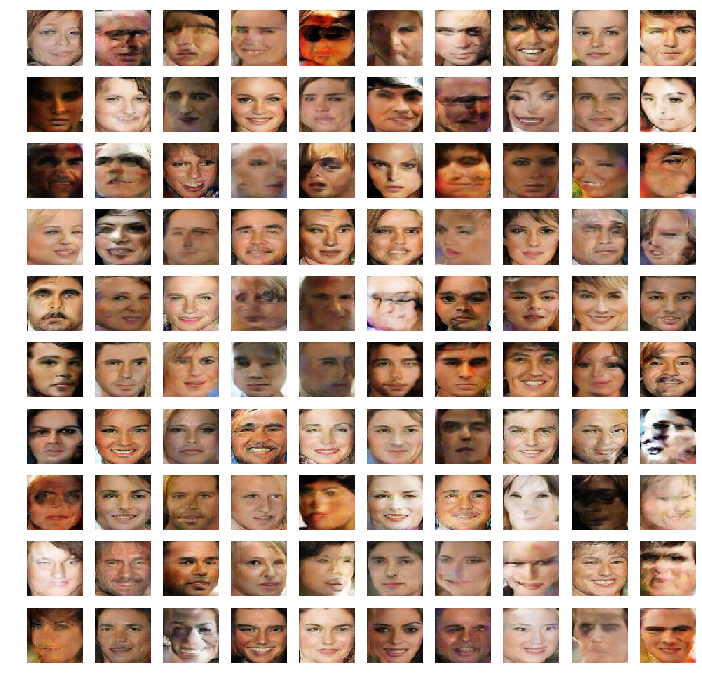

In [39]:
# generate images
X  = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
pyplot.figure(figsize=(12,12))
plot_generated(X, 10)

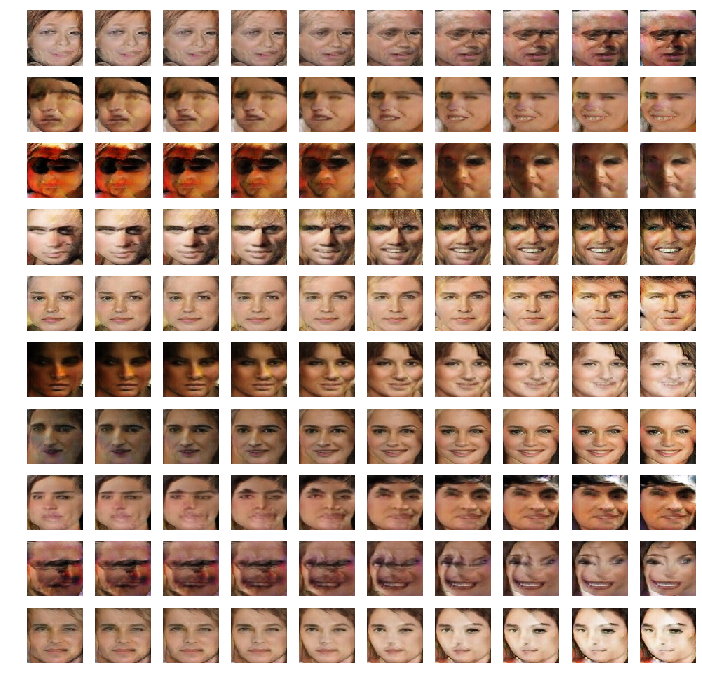

In [40]:
# interpolate pairs
results = None
for i in range(0, 20, 2):
    # interpolate points in latent space
    interpolated = interpolate_points(latent_points[i], latent_points[i+1])
    # generate images
    X = model.predict(interpolated)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    if results is None:
        results = X
    else:
        results = vstack((results, X))
        
# plot the result
pyplot.figure(figsize=(12,12))
plot_generated(results, 10)

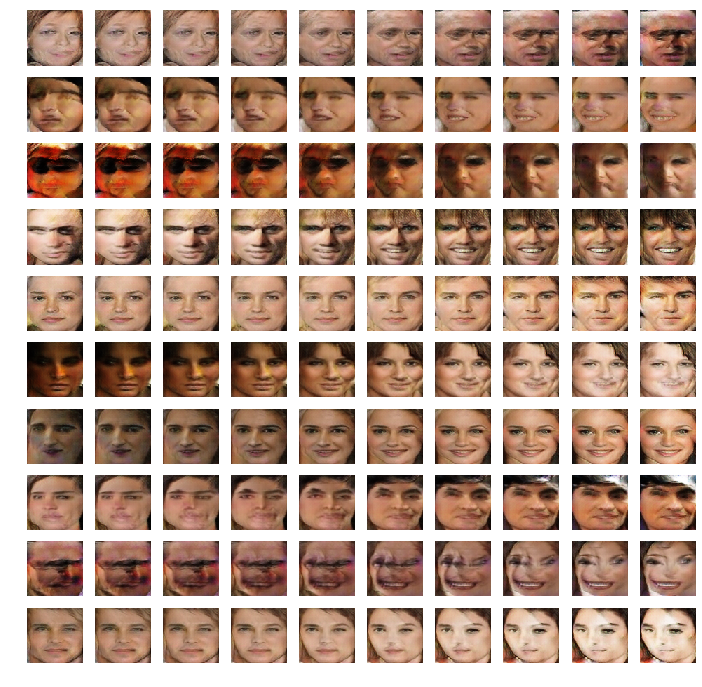

In [41]:
# slerp pairs for better interpolation
results = None
for i in range(0, 20, 2):
    # interpolate points in latent space
    interpolated = interpolate_points(latent_points[i], latent_points[i+1])
    # generate images
    X = model.predict(interpolated)
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    if results is None:
        results = X
    else:
        results = vstack((results, X))
    
# plot the result
pyplot.figure(figsize=(12,12))
plot_generated(results, 10)

## Vector Arithmetic
We will find specific instances so that we can perform the function:

smiling woman - neutral woman + neutral man = smiling man

We will use images with the following indexes:
* Smiling Woman: 8, 62, 72
* Neutral Woman: 9, 26, 95
* Neutral Man: 10, 41, 52

We use an average of a few faces with each desired property so that the results are more robust.

In [43]:
# average list of latent space vectors
def average_points(points, ix):
    # convert to zero offset points
    zero_ix = [i-1 for i in ix]
    # retrieve required points
    vectors = points[zero_ix]
    # average the vectors
    avg_vector = mean(vectors, axis=0)
    # combine original and avg vectors
    all_vectors = vstack((vectors, avg_vector))
    return all_vectors

# create a plot of generated images
def plot_generated(examples, rows, cols):
    # plot images
    for i in range(rows * cols):
        # define subplot
        pyplot.subplot(rows, cols, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :])
    pyplot.show()

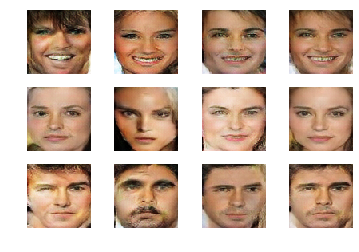

In [53]:
# load model
model = load_model('generator_model_030.h5')

# retrieve specific points
np.random.seed(42)
latent_points = generate_latent_points(100, 100)
smiling_woman_ix = [8, 62, 72]
neutral_woman_ix = [9, 26, 95]
neutral_man_ix = [10, 41, 52]

# average and vectors
smiling_woman = average_points(latent_points, smiling_woman_ix)
neutral_woman = average_points(latent_points, neutral_woman_ix)
neutral_man = average_points(latent_points, neutral_man_ix)
all_vectors = vstack((smiling_woman, neutral_woman, neutral_man))

# generate images
images = model.predict(all_vectors)
images = (images + 1) / 2.0
plot_generated(images, 3, 4)

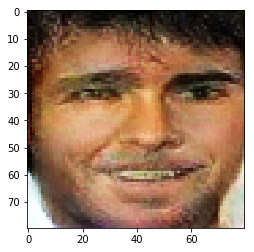

In [54]:
# smiling woman - neutral woman + neutral man = smiling man
result_vector = smiling_woman[-1] - neutral_woman[-1] + neutral_man[-1]
# generate image
result_vector = expand_dims(result_vector, 0)
result_image = model.predict(result_vector)
# scale pixel values
result_image = (result_image + 1) / 2.0
pyplot.imshow(result_image[0])
pyplot.show()